<a id="table-of-contents"></a>

![Status: Complete](https://img.shields.io/badge/status-complete-brightgreen)
![Python](https://img.shields.io/badge/python-3.10-blue)
![Coverage](https://img.shields.io/badge/coverage-95%25-yellowgreen)
![License](https://img.shields.io/badge/license-MIT-green)

# 📖 Table of Contents
[🗂️ Data Setup](#data-setup)  
- [🧾 Sample Data](#sample-data)  
- [🛠️ Experiment Setup](#experiment-setup)  
- [⚙️ Other Experiment Parameters](#other-experiment-parameters)  
- [🔧 Central Control Panel](#central-control-panel)

[🔀 Randomization Methods](#randomization-methods)  
- [🔄 Simple Randomization](#simple-randomization)  
- [🧬 Stratified Sampling](#stratified-sampling)  
- [🔁 Block Randomization](#block-randomization)  
- [🧯 Match Pair Randomization](#match-pair-randomization)  
- [🗃️ Cluster Randomization](#cluster-randomization)  
- [📉 CUPED](#cuped)
- [🕸️ Network Effects](#network-effects)

[📈 EDA](#eda)  
- [🔍 Normality](#normality)  
- [🧪 Variance Homogeneity Check](#variance-homogeneity-check)  
- [🧬 Test Family](#test-family)

[🧪 AA Testing](#aa-testing)  
- [🧬 Outcome Similarity Test](#outcome-similarity-test)  
- [⚖️ Sample Ratio Mismatch](#sample-ratio-mismatch)  
- [📊 AA Test Visualization](#aa-test-visualization)  
- [🎲 Type I Error Simulation](#type-i-error-simulation)

[⚡ Power Analysis](#power-analysis)  
- [⚙️ Setup Inputs + Config](#setup-inputs--config-values)  
- [📊 Baseline Estimation from Data](#baseline-from-data)  
- [📈 Minimum Detectable Effect](#minimum-detectable-effect)  
- [📐 Required Sample Size](#required-sample-size)  
- [📊 Power Analysis Summary](#power-analysis-summary)

[🧪 AB Testing](#ab-testing)

[📉 Results](#results)  
- [🧾 Summaries](#summaries)  
- [📊 Visualization](#results-visualization)  
- [🎯 95% Confidence Intervals](#confidence-intervals)  
- [📈 Lift Analysis](#lift-analysis)  
- [✅ Final Conclusion](#final-conclusion)

[⏱️ How Long?](#how-long)
- [🧭 Monitoring Dashboard Components](#monitoring-dashboard-components)

[🔍 Post Hoc Analysis](#post-hoc-analysis)  
- [🧩 Segmented Lift](#segmented-lift)  
- [🚦 Guardrail Metrics](#guardrail-metrics)  
- [🧠 Correcting for Multiple Comparisons](#multiple-comparisons)
- [🪄 Novelty Effects](#novelty-effects)
- [🎯 Primacy Effect](#primacy-effect)
- [📦 Rollout Simulation](#rollout-simulation)
- [🧪 A/B Test Holdouts](#ab-test-holdouts)
- [🚫 AB Limits](#ab-test-limits)
___



<a id="data-setup"></a>
# 🗂️ Data Setup

<a id="sample-data"></a>
#### 🧾 Sample data

In [1]:
# Display Settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML

# Set Seed 
my_seed=1995

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
from scipy.stats import (
    ttest_ind,
    ttest_rel,
    chi2_contingency,
    mannwhitneyu,
    levene,
    shapiro
)
import statsmodels.api as sm
from statsmodels.stats.power import (
    TTestIndPower,
    TTestPower,
    FTestAnovaPower,
    NormalIndPower
)
from sklearn.model_selection import train_test_split

In [2]:
observations_count = 1000

np.random.seed(my_seed) # For reproducibility
users = pd.DataFrame({
    # identifiers
    'user_id': range(1, observations_count+1),

    # segmentation features
    'platform': np.random.choice(['iOS', 'Android'], size=observations_count, p=[0.6, 0.4]), # 60% iOS, 40% Android
    'device_type': np.random.choice(['mobile', 'desktop'], size=observations_count, p=[0.7, 0.3]),
    'user_tier': np.random.choice(['new', 'returning'], size=observations_count, p=[0.4, 0.6]),
    'region': np.random.choice(['North', 'South', 'East', 'West'], size=observations_count, p=[0.25, 0.25, 0.25, 0.25]),
    'plan_type': np.random.choice(['basic', 'premium', 'pro'], size=observations_count, p=[0.6, 0.3, 0.1]), # 60% basic, 30% premium, 10% pro
    'city': np.random.choice(['ny', 'sf', 'chicago', 'austin'], size=observations_count),

    # outcome metrics
    'engagement_score': np.random.normal(50, 15, observations_count), # Simulated user engagement scores
    'converted': np.random.binomial(n=1, p=0.1, size=observations_count), # Simulated binary conversion: ~10% baseline
    'past_purchase_count': np.random.normal(loc=50, scale=10, size=observations_count), # pre_experiment_metric for CUPED randomization
    'bounce_rate': np.nan # will be simulated later
})

# Simulate  a guardrail metric (bounce_rate)
np.random.seed(my_seed)
users['bounce_rate'] = np.where(
    users['converted'] == 1,
    np.random.normal(loc=0.2, scale=0.05, size=observations_count),
    np.random.normal(loc=0.6, scale=0.10, size=observations_count)
)
users['bounce_rate'] = users['bounce_rate'].clip(0, 1) # Bound bounce_rate between 0 and 1

users

,user_id,platform,device_type,user_tier,region,plan_type,city,engagement_score,converted,past_purchase_count,bounce_rate
0,1,iOS,mobile,new,North,premium,austin,53.437537,0,50.653869,0.660153
1,2,iOS,mobile,returning,North,basic,ny,48.924673,1,26.451597,0.126471
2,3,iOS,desktop,returning,South,premium,austin,80.179294,0,43.112520,0.552955
3,4,iOS,mobile,new,North,premium,austin,40.441478,0,48.339368,0.665883
4,5,Android,mobile,returning,West,basic,chicago,54.171571,0,56.578205,0.503212
...,...,...,...,...,...,...,...,...,...,...,...
995,996,iOS,desktop,returning,North,basic,sf,35.814776,0,55.156336,0.722611
996,997,iOS,mobile,new,South,pro,ny,35.693639,0,48.434500,0.522644
997,998,Android,desktop,returning,South,premium,chicago,33.913119,0,30.591967,0.644316
998,999,iOS,mobile,new,West,premium,sf,40.789684,0,44.760253,0.540618


<a id="experiment-setup"></a>

#### 🛠️ Experiment Setup

In [3]:
# 1. Main outcome variable you're testing
outcome_metric_col = 'engagement_score'

# 2. Metric type: 'binary', 'continuous', or 'categorical'
outcome_metric_datatype = 'continuous'

# 3. Group assignment (to be generated)
group_labels = ('control', 'treatment')

# 4. Experimental design variant: independent or paired
variant = 'independent'  # Options: 'independent' (supported), 'paired' (not supported yet)

# 5. Optional: Unique identifier for each observation (can be user_id, session_id, etc.)
observation_id_col = 'user_id'

# 6. Optional: Pre-experiment metric for CUPED, if used
pre_experiment_metric = 'past_purchase_count'  # Can be None

<a id="other-experiment-parameters"></a>
#### ⚙️ Other Experiment Parameters

In [4]:
# Number of groups in the experiment (e.g., 2 for A/B test, 3 for A/B/C test)
group_count = len(group_labels)

# Column name used to store assigned group after randomization
group_col = 'group'

# Randomization method to assign users to groups
# Options: 'simple', 'stratified', 'block', 'matched_pair', 'cluster', 'cuped'
randomization_method = "simple"

<a id="central-control-panel"></a>
#### 🔧 Central Control Panel

In [5]:
test_config = {
    # Core experiment setup
    'outcome_metric_col'     : outcome_metric_col,         # Main metric to analyze (e.g., 'engagement_score')
    'outcome_metric_datatype': outcome_metric_datatype,    # One of: 'binary', 'continuous', 'categorical'
    'group_labels'           : group_labels,               # Tuple of (control, treatment) group names
    'group_count'            : group_count,                # Number of groups (usually 2 for A/B tests)
    'variant'                : variant,                    # 'independent' or 'paired'
    'observation_id_col'     : observation_id_col,         # Unique identifier for each observation
    'pre_experiment_metric'  : pre_experiment_metric,      # Used for CUPED adjustment (if any)

    # Diagnostic results — filled after EDA/assumptions check
    'normality'              : None,  # Will be set based on Shapiro-Wilk or visual tests
    'equal_variance'         : None,  # Will be set using Levene’s/Bartlett’s test
    'family'                 : None   # Test family → 'z_test', 't_test', 'anova', 'chi_square', etc.
}

from IPython.display import HTML
display(HTML(f"<pre style='color:teal; font-size:14px;'>{json.dumps(test_config, indent=4)}</pre>"))


[Back to the top](#table-of-contents)
___


<a id="randomization-methods"></a>
<h1>🔀 Randomization Methods</h1>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Randomization is used to ensure that observed differences in outcome metrics are due to the experiment, not pre-existing differences.</p>

<ul>
  <li>Prevents <strong>selection bias</strong> (e.g., users self-selecting into groups)</li>
  <li>Balances <strong>confounding factors</strong> like platform, region, or past behavior</li>
  <li>Enables <strong>valid inference</strong> through statistical testing</li>
</ul>

</details>


<a id="simple-randomization"></a>

#### 🔄 Simple Randomization

<details>
  <summary><strong>📖 Click to Expand</strong></summary>

  <p><strong>Each user is assigned to control or treatment with equal probability, independent of any characteristics.</strong></p>

  <strong>✅ When to Use:</strong>
  <ul>
    <li>Sample size is <em>large enough</em> to ensure natural balance</li>
    <li>No strong concern about <em>confounding variables</em></li>
    <li>Need a <em>quick, default assignment</em> strategy</li>
  </ul>

  <strong>🛠️ How It Works:</strong>
  <ul>
    <li>Assign each user randomly (e.g., 50/50 split)</li>
    <li>No grouping, segmentation, or blocking involved</li>
    <li>Groups are expected to balance out on average</li>
  </ul>
</details>


In [6]:
def apply_simple_randomization(df, group_labels=group_labels, group_col=group_col, seed=my_seed):
    """
    Randomly assigns each row to one of the specified groups.

    Parameters:
    - df: pandas DataFrame containing observations
    - group_labels: tuple of group names (default = ('control', 'treatment'))
    - group_col: name of the column to store group assignments
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with an added group assignment column
    """
    np.random.seed(seed)
    df[group_col] = np.random.choice(group_labels, size=len(df), replace=True)
    return df

<a id="stratified-sampling"></a>

<h4>🔄 Stratified Sampling</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Ensures that key segments (e.g., platform, region) are evenly represented across control and treatment.</p>

<h5>When to Use</h5>
<ul>
  <li>User base is <strong>naturally skewed</strong> (e.g., 70% mobile, 30% desktop)</li>
  <li>Important to control for <strong>known confounders</strong> like geography or device</li>
  <li>You want balance <strong>within subgroups</strong>, not just overall</li>
</ul>

<h5>How It Works</h5>
<ul>
  <li>Pick a stratification variable (e.g., platform)</li>
  <li>Split population into strata (groups)</li>
  <li>Randomly assign users <strong>within each stratum</strong></li>
</ul>

</details>


In [7]:
def apply_stratified_randomization(df, stratify_col, group_labels=group_labels, group_col=group_col, seed=my_seed):
    """
    Performs stratified randomization to assign rows into multiple groups while maintaining balance across strata.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - stratify_col: column to balance across (e.g., platform, region)
    - group_labels: list or tuple of group names
    - group_col: name of the column to store group assignments
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with a new group assignment column
    """
    np.random.seed(seed)
    df[group_col] = None
    n_groups = len(group_labels)

    # Stratify and assign
    for stratum_value, stratum_df in df.groupby(stratify_col):
        shuffled = stratum_df.sample(frac=1, random_state=seed)
        group_assignments = np.tile(group_labels, int(np.ceil(len(shuffled) / n_groups)))[:len(shuffled)]
        df.loc[shuffled.index, group_col] = group_assignments

    return df

<a id="block-randomization"></a>

<h4>🔄 Block Randomization</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Groups users into fixed-size blocks and randomly assigns groups within each block.</p>

<h5>When to Use</h5>
<ul>
  <li>Users arrive in <strong>time-based batches</strong> (e.g., daily cohorts)</li>
  <li>Sample size is <strong>small</strong> and needs enforced balance</li>
  <li>You want to minimize <strong>temporal or ordering effects</strong></li>
</ul>

<h5>How It Works</h5>
<ul>
  <li>Create blocks based on order or ID (e.g., every 10 users)</li>
  <li>Randomize assignments <strong>within each block</strong></li>
  <li>Ensures near-equal split in every batch</li>
</ul>

</details>


In [8]:
def apply_block_randomization(df, observation_id_col, group_col=group_col, block_size=10, group_labels=group_labels, seed=my_seed):
    """
    Assigns group labels using block randomization to ensure balance within fixed-size blocks.

    Parameters:
    - df: DataFrame to assign groups
    - observation_id_col: Unique ID to sort and block on (e.g., user_id)
    - group_col: Name of column to store assigned group labels
    - block_size: Number of observations in each block
    - group_labels: Tuple or list of group names (e.g., ('control', 'treatment', 'variant_B'))
    - seed: Random seed for reproducibility

    Returns:
    - DataFrame with a new column [group_col] indicating assigned group
    """
    np.random.seed(seed)
    df = df.sort_values(observation_id_col).reset_index(drop=True).copy()
    n_groups = len(group_labels)

    # Create block ID per row
    df['_block'] = df.index // block_size

    # Assign groups within each block
    group_assignments = []
    for _, block_df in df.groupby('_block'):
        block_n = len(block_df)
        reps = int(np.ceil(block_n / n_groups))
        candidates = np.tile(group_labels, reps)[:block_n]
        np.random.shuffle(candidates)
        group_assignments.extend(candidates)

    df[group_col] = group_assignments
    df = df.drop(columns=['_block'])

    return df

<a id="match-pair-randomization"></a>

<h4>🔄 Match Pair Randomization</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Participants are <strong>paired based on similar characteristics</strong> before random group assignment.  
This reduces variance and improves <strong>statistical power</strong> by ensuring balance on key covariates.</p>

<h5>When to Use</h5>
<ul>
  <li>Small sample size with high risk of <strong>confounding</strong></li>
  <li>Outcomes influenced by user traits (e.g., <strong>age, income, tenure</strong>)</li>
  <li>Need to <strong>minimize variance</strong> across groups</li>
</ul>

<h5>How It Works</h5>
<ol>
  <li>Identify important covariates (e.g., age, purchase history)</li>
  <li>Sort users by those variables</li>
  <li>Create matched pairs (or small groups)</li>
  <li>Randomly assign one to <strong>control</strong>, the other to <strong>treatment</strong></li>
</ol>

</details>


In [9]:
def apply_matched_pair_randomization(df, sort_col, group_col=group_col, group_labels=group_labels):
    """
    Assigns groups using matched-pair randomization based on a sorting variable.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - sort_col: column used to sort users before pairing (e.g., engagement score)
    - group_col: name of the column to store group assignments
    - group_labels: tuple of group names (e.g., ('control', 'treatment'))

    Returns:
    - DataFrame with alternating group assignments within sorted pairs
    """
    # Sort by matching variable so similar users are adjacent
    df = df.sort_values(by=sort_col).reset_index(drop=True)

    # Cycle through group labels for each row
    df[group_col] = [group_labels[i % len(group_labels)] for i in range(len(df))]

    return df

<a id="cluster-randomization"></a>

<h4>🔄 Cluster Randomization</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Entire <strong>groups or clusters</strong> (e.g., cities, stores, schools) are assigned to control or treatment.  
Used when it's impractical or risky to randomize individuals within a cluster.</p>

<h5>When to Use</h5>
<ul>
  <li>Users naturally exist in <strong>groups</strong> (e.g., teams, locations, devices)</li>
  <li>There's a risk of <strong>interference</strong> between users (e.g., word-of-mouth)</li>
  <li>Operational or tech constraints prevent individual-level randomization</li>
</ul>

<h5>How It Works</h5>
<ol>
  <li>Define the cluster unit (e.g., store, city)</li>
  <li>Randomly assign each cluster to control or treatment</li>
  <li>All users within the cluster inherit the group assignment</li>
</ol>

</details>


In [10]:
def apply_cluster_randomization(df, cluster_col, group_col=group_col, group_labels=group_labels, seed=my_seed):
    """
    Assigns groups using cluster-level randomization — all observations in a cluster
    receive the same group assignment.

    Parameters:
    - df: pandas DataFrame to assign groups to
    - cluster_col: column representing the cluster unit (e.g., city, store)
    - group_col: name of the column where group labels will be stored
    - group_labels: tuple of group names to randomly assign (e.g., ('control', 'treatment'))
    - seed: random seed for reproducibility

    Returns:
    - DataFrame with assigned groups at the cluster level
    """
    np.random.seed(seed)

    # Unique clusters (e.g., unique city/store values)
    unique_clusters = df[cluster_col].unique()

    # Randomly assign each cluster to a group
    cluster_assignments = dict(
        zip(unique_clusters, np.random.choice(group_labels, size=len(unique_clusters)))
    )

    # Map group assignments to full DataFrame
    df[group_col] = df[cluster_col].map(cluster_assignments)

    return df

<a id="cuped"></a>
<h4>🔄 CUPED</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Controlled Pre-Experiment Data: A statistical adjustment that uses <strong>pre-experiment behavior</strong> to reduce variance and improve power.  
It helps detect smaller effects without increasing sample size.</p>

<h5>When to Use</h5>
<ul>
  <li>You have reliable <strong>pre-experiment metrics</strong> (e.g., past spend, engagement)</li>
  <li>You want to <strong>reduce variance</strong> and improve test sensitivity</li>
  <li>You’re dealing with <strong>small lifts</strong> or <strong>costly sample sizes</strong></li>
</ul>

<h5>How It Works</h5>
<ol>
  <li>Identify a pre-period metric <strong>correlated with your outcome</strong></li>
  <li>Use regression to compute an adjustment (theta)</li>
  <li>Subtract the correlated component from your outcome metric</li>
  <li>Analyze the adjusted metric instead of the raw one</li>
</ol>

</details>


In [11]:
def apply_cuped(
    df,
    pre_metric,
    outcome_metric_col,  # observed outcome column (e.g., engagement_score)
    outcome_col=None,
    group_col=group_col,
    group_labels=group_labels,
    seed=my_seed
):
    """
    Applies CUPED (Controlled Pre-Experiment Data) adjustment to reduce variance
    in the outcome metric using a pre-experiment covariate.

    CUPED is a post-randomization technique that reduces variance by adjusting the 
    observed outcome using a baseline (pre-metric) variable that is correlated 
    with the outcome.

    Parameters:
    ----------
    df : pandas.DataFrame
        Input DataFrame containing experiment data.
    pre_metric : str
        Column name of the pre-experiment covariate (e.g., 'past_purchase_count').
        This is the variable used to compute the adjustment factor (theta).
    outcome_metric_col : str
        Column name of the original observed outcome (e.g., 'engagement_score') 
        that you are comparing across groups.
    outcome_col : str, default=None
        Name of the new column where the adjusted outcome will be stored.
    group_col : str
        Column indicating the experiment group assignment (e.g., 'control' vs 'treatment').
    group_labels : tuple
        Tuple containing the names of the experiment groups.
    seed : int
        Random seed for reproducibility (used only if randomness is introduced later).

    Returns:
    -------
    df : pandas.DataFrame
        DataFrame with an additional column [outcome_col] containing the CUPED-adjusted outcome.
    """
    np.random.seed(seed)

    # Step 1: Use actual observed experiment outcome
    y = df[outcome_metric_col].values

    # Step 2: Regress outcome on pre-metric to estimate correction factor (theta)
    X = sm.add_constant(df[[pre_metric]])
    theta = sm.OLS(y, X).fit().params[pre_metric]

    # Step 3: Apply CUPED adjustment and save in new column
    if outcome_col is None:
        outcome_col = f'{outcome_metric_col}_cuped_adjusted'
    df[outcome_col] = y - theta * df[pre_metric]

    return df


In [12]:
# Apply randomization method
if randomization_method == "simple":
    users = apply_simple_randomization(users, group_col=group_col, seed=my_seed)

elif randomization_method == "stratified":
    users = apply_stratified_randomization(users, stratify_col='platform', group_col=group_col, seed=my_seed)

elif randomization_method == "block":
    users = apply_block_randomization(users, observation_id_col='user_id', group_col=group_col, block_size=10, seed=my_seed)

elif randomization_method == "matched_pair":
    users = apply_matched_pair_randomization(users, sort_col=outcome_metric_col, group_col=group_col, seed=my_seed)

elif randomization_method == "cluster":
    users = apply_cluster_randomization(users, cluster_col='city', group_col=group_col, seed=my_seed)

elif randomization_method == "cuped":
    users = apply_cuped(users, pre_metric='past_purchase_count', outcome_metric_col=outcome_metric_col, group_col=group_col, group_labels=group_labels, seed=my_seed)
    # Update global outcome to CUPED-adjusted version
    outcome_metric_col = f"{outcome_metric_col}_cuped_adjusted"
else:
    raise ValueError(f"❌ Unsupported randomization method: {randomization_method}")

users


,user_id,platform,device_type,user_tier,region,plan_type,city,engagement_score,converted,past_purchase_count,bounce_rate,group
0,1,iOS,mobile,new,North,premium,austin,53.437537,0,50.653869,0.660153,control
1,2,iOS,mobile,returning,North,basic,ny,48.924673,1,26.451597,0.126471,control
2,3,iOS,desktop,returning,South,premium,austin,80.179294,0,43.112520,0.552955,control
3,4,iOS,mobile,new,North,premium,austin,40.441478,0,48.339368,0.665883,treatment
4,5,Android,mobile,returning,West,basic,chicago,54.171571,0,56.578205,0.503212,treatment
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,iOS,desktop,returning,North,basic,sf,35.814776,0,55.156336,0.722611,treatment
996,997,iOS,mobile,new,South,pro,ny,35.693639,0,48.434500,0.522644,control
997,998,Android,desktop,returning,South,premium,chicago,33.913119,0,30.591967,0.644316,control
998,999,iOS,mobile,new,West,premium,sf,40.789684,0,44.760253,0.540618,treatment


<a id="network-effects"></a>
<h4>🕸️ Network Effects & SUTVA Violations</h4>

<details><summary><strong>📖 When Randomization Assumptions Break (Click to Expand)</strong></summary>

Most A/B tests assume the **Stable Unit Treatment Value Assumption (SUTVA)** — meaning:
- A user's outcome depends *only* on their own treatment assignment.
- One unit's treatment **does not influence** another unit’s outcome.

##### 🧪 Why It Matters
If users in different groups interact:
- Control group behavior may be **influenced by treatment group exposure**.
- This **biases your estimates** and **dilutes treatment effect**.
- Standard tests may incorrectly **accept the null hypothesis** due to **spillover**.

This assumption **breaks down** in experiments involving **social behavior**, **multi-user platforms**, or **ecosystem effects**.
##### ⚠️ Common Violation Scenarios
- 🛍️ **Marketplace platforms** (e.g., sellers and buyers interact)
- 🧑‍🤝‍🧑 **Social features** (e.g., follows, likes, comments, feeds)
- 📲 **Referrals / network effects** (e.g., invites, rewards)
- 💬 **Chat and collaboration tools** (e.g., Slack, Teams)

##### 🧩 Solutions (If You Suspect Interference)
| Strategy                  | Description                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| Cluster Randomization     | Randomize **at group level** (e.g., friend group, region, org ID)          |
| Isolation Experiments     | Only roll out to **fully disconnected segments** (e.g., one region only)   |
| Network-Based Metrics     | Include **network centrality / exposure** as covariates                    |
| Post-Experiment Checks    | Monitor if control group was exposed indirectly (e.g., referrals, shared UIs) |
| Simulation-Based Designs  | Use agent-based or graph simulations to estimate contamination risk        |
</details>

[Back to the top](#table-of-contents)
___


<a id="eda"></a>
# 📈 EDA

Exploratory Data Analysis validates core statistical assumptions before testing begins.

<a id="normality"></a>

<h4>🔍 Normality</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Checks whether your outcome metric follows a <strong>normal distribution</strong>, which is a key assumption for <strong>parametric tests</strong> like t-test or ANOVA.</p>

<ul>
  <li>Use <strong>Shapiro-Wilk test</strong> or visual tools (histograms, Q-Q plots).</li>
  <li>Helps determine whether to use parametric or non-parametric tests.</li>
  <li>If data is non-normal, switch to <strong>Mann-Whitney U</strong> or <strong>Wilcoxon</strong>.</li>
</ul>

</details>


In [13]:
def test_normality(df, outcome_metric_col, group_col, group_labels):
    results = {}
    for group in group_labels:
        group_data = df[df[group_col] == group][outcome_metric_col]
        stat, p = shapiro(group_data)
        results[group] = {'statistic': stat, 'p_value': p, 'normal': p > 0.05}
    return results

In [14]:
normality_results = test_normality(users, outcome_metric_col=outcome_metric_col, group_col='group', group_labels=group_labels)

print("Normality test (Shapiro-Wilk) results:")
for group, result in normality_results.items():
    print(f"{group}: p = {result['p_value']:.4f} → {'Normal' if result['normal'] else 'Non-normal'}")

Normality test (Shapiro-Wilk) results:
control: p = 0.2230 → Normal
treatment: p = 0.6053 → Normal


In [15]:
# Assume both groups must be normal to proceed with parametric tests
test_config['normality'] = all(result['normal'] for result in normality_results.values())
test_config


{'outcome_metric_col': 'engagement_score',
 'outcome_metric_datatype': 'continuous',
 'group_labels': ('control', 'treatment'),
 'group_count': 2,
 'variant': 'independent',
 'observation_id_col': 'user_id',
 'pre_experiment_metric': 'past_purchase_count',
 'normality': True,
 'equal_variance': None,
 'family': None}

<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="variance-homogeneity-check"></a>

<h4>🔍 Variance Homogeneity Check</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Tests whether the <strong>variances between groups are equal</strong>, which affects the validity of t-tests and ANOVA.</p>

<ul>
  <li>Performed using <strong>Levene’s test</strong> or <strong>Bartlett’s test</strong>.</li>
  <li>If variances are unequal, use <strong>Welch's t-test</strong> instead.</li>
  <li>Unequal variances do not invalidate analysis but change the test used.</li>
</ul>

</details>


In [16]:
def test_equal_variance(df, outcome_metric_col, group_col, group_labels):
    group_data = [df[df[group_col] == label][outcome_metric_col] for label in group_labels]
    stat, p = levene(*group_data)
    return {'statistic': stat, 'p_value': p, 'equal_variance': p > 0.05}


In [17]:
variance_result = test_equal_variance(users, outcome_metric_col=outcome_metric_col, group_col='group', group_labels=group_labels)
variance_result

{'statistic': 0.08918799756611763,
 'p_value': 0.7652741675085144,
 'equal_variance': True}

In [18]:
print(f"Levene’s test: p = {variance_result['p_value']:.4f} → {'Equal variances' if variance_result['equal_variance'] else 'Unequal variances'}")
test_config['equal_variance'] = variance_result['equal_variance']
test_config



Levene’s test: p = 0.7653 → Equal variances


{'outcome_metric_col': 'engagement_score',
 'outcome_metric_datatype': 'continuous',
 'group_labels': ('control', 'treatment'),
 'group_count': 2,
 'variant': 'independent',
 'observation_id_col': 'user_id',
 'pre_experiment_metric': 'past_purchase_count',
 'normality': True,
 'equal_variance': True,
 'family': None}

<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="test-family"></a>

<h4>🔍 Test Family</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Selects the appropriate statistical test based on:</p>
<ul>
  <li>Outcome data type (binary, continuous, categorical)</li>
  <li>Distributional assumptions (normality, variance)</li>
  <li>Number of groups and experiment structure (independent vs paired)</li>
</ul>

<p>This step <strong>automatically maps to the correct test</strong> (e.g., t-test, z-test, chi-square, ANOVA).</p>

<h6>🧪 Experiment Type → Test Family Mapping</h6>

<table>
  <tr><th>Outcome Metric</th><th>Normality</th><th>Group Count</th><th>Selected Test Family</th></tr>
  <tr><td><strong>binary</strong></td><td>—</td><td>2</td><td><code>z_test</code></td></tr>
  <tr><td><strong>binary</strong></td><td>—</td><td>3+</td><td><code>chi_square</code></td></tr>
  <tr><td><strong>continuous</strong></td><td>✅</td><td>2</td><td><code>t_test</code></td></tr>
  <tr><td><strong>continuous</strong></td><td>✅</td><td>3+</td><td><code>anova</code></td></tr>
  <tr><td><strong>continuous</strong></td><td>❌</td><td>2</td><td><code>non_parametric</code> (Mann-Whitney U)</td></tr>
  <tr><td><strong>continuous</strong></td><td>❌</td><td>3+</td><td><code>non_parametric</code> (Kruskal-Wallis)</td></tr>
  <tr><td><strong>categorical</strong></td><td>—</td><td>2</td><td><code>chi_square</code></td></tr>
  <tr><td><strong>categorical</strong></td><td>—</td><td>3+</td><td><code>chi_square</code></td></tr>
</table>

</details>


In [19]:
def determine_test_family(test_config):
    """
    Decide which family of statistical test to use based on:
    - outcome data type: binary / continuous / categorical
    - group count: 2 or 3+
    - variant: independent or paired (optional for family level)
    - normality assumption: passed or not
    """

    data_type = test_config['outcome_metric_datatype']
    group_count = test_config['group_count']
    variant = test_config['variant']
    normality = test_config['normality']

    # Binary outcome → Z-test for 2 groups, Chi-square for 3+ groups
    if data_type == 'binary':
        if group_count == 2:
            return 'z_test'           # Compare proportions across 2 groups
        else:
            return 'chi_square'      # 2x3+ contingency test

    # Continuous outcome → check for normality and group count
    elif data_type == 'continuous':
        if not normality:
            return 'non_parametric'  # Mann-Whitney U or Kruskal-Wallis
        if group_count == 2:
            return 't_test'          # Independent or paired t-test
        else:
            return 'anova'           # One-way ANOVA

    # Categorical outcome → Chi-square always
    elif data_type == 'categorical':
        return 'chi_square'

    else:
        raise ValueError(f"Unsupported outcome_metric_datatype: {data_type}")


In [20]:
test_config['family'] = determine_test_family(test_config)
test_config

print(f"✅ Selected test family: {test_config['family']}")

{'outcome_metric_col': 'engagement_score',
 'outcome_metric_datatype': 'continuous',
 'group_labels': ('control', 'treatment'),
 'group_count': 2,
 'variant': 'independent',
 'observation_id_col': 'user_id',
 'pre_experiment_metric': 'past_purchase_count',
 'normality': True,
 'equal_variance': True,
 'family': 't_test'}

✅ Selected test family: t_test


[Back to the top](#table-of-contents)
___


<a id="aa-testing"></a>

<h1>🧪 AA Testing</h1>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>A/A testing is a <strong>preliminary experiment</strong> where both groups (e.g., “control” and “treatment”) receive the exact same experience. It's used to validate the experimental setup before running an actual A/B test.</p>

<p><strong>What Are We Checking?</strong></p>
<ul>
  <li>Are users being assigned fairly and randomly?</li>
  <li>Are key outcome metrics statistically similar across groups?</li>
  <li>Can we trust the experimental framework?</li>
</ul>

<p><strong>Why A/A Testing Matters</strong></p>
<ul>
  <li><strong>Validates Randomization</strong> — Confirms the groups are balanced at baseline (no bias or leakage)</li>
  <li><strong>Detects SRM (Sample Ratio Mismatch)</strong> — Ensures the actual split (e.g., 50/50) matches what was intended</li>
  <li><strong>Estimates Variability</strong> — Helps calibrate variance for accurate power calculations later</li>
  <li><strong>Trust Check</strong> — Catches bugs in assignment logic, event tracking, or instrumentation</li>
</ul>

<p><strong>A/A Test Process</strong></p>
<ol>
  <li><strong>Randomly assign users</strong> into two equal groups — Just like you would for an A/B test (e.g., control vs treatment)</li>
  <li><strong>Measure key outcome</strong> — This depends on your experiment type:
    <ul>
      <li><code>binary</code> → conversion rate</li>
      <li><code>continuous</code> → avg. revenue, time spent</li>
      <li><code>categorical</code> → feature adoption, plan selected</li>
    </ul>
  </li>
  <li><strong>Run statistical test</strong>:
    <ul>
      <li><code>binary</code> → Z-test or Chi-square</li>
      <li><code>continuous</code> → t-test</li>
      <li><code>categorical</code> → Chi-square test</li>
    </ul>
  </li>
  <li><strong>Check SRM</strong> — Use a chi-square goodness-of-fit test to detect assignment imbalances</li>
</ol>

<p><strong>Possible Outcomes</strong></p>
<table>
  <thead>
    <tr>
      <th><strong>Result</strong></th>
      <th><strong>Interpretation</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>No significant difference</td>
      <td>✅ Randomization looks good. Test setup is sound.</td>
    </tr>
    <tr>
      <td>Statistically significant difference</td>
      <td>⚠️ Something’s off — check assignment logic, instrumentation, or sample leakage</td>
    </tr>
  </tbody>
</table>

<p><em>Run A/A tests whenever you launch a new experiment framework, roll out a new randomizer, or need to build stakeholder trust.</em></p>

</details>


<a id="outcome-similarity-test"></a>

<h4>🧬 Outcome Similarity Test</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Compares the <strong>outcome metric across groups</strong> to ensure no significant differences exist when there shouldn't be any — usually used during <strong>A/A testing</strong> or pre-experiment validation.</p>

<ul>
  <li>Helps detect setup issues like <strong>biased group assignment</strong> or <strong>data leakage</strong>.</li>
  <li>Null Hypothesis: <strong>No difference</strong> in outcomes between control and treatment.</li>
  <li>Uses the same statistical test as the main A/B test (e.g., t-test, z-test, chi-square).</li>
</ul>

</details>


In [21]:
def run_outcome_similarity_test(
    df,
    group_col,
    metric_col,
    test_family,
    variant=None,
    group_labels=('control', 'treatment'),
    alpha=0.05,
    verbose=True
):
    """
    Runs a similarity test between two groups based on test_family and variant.

    Parameters:
    - df: pandas DataFrame
    - group_col: column with group assignment
    - metric_col: outcome metric
    - test_family: one of ['z_test', 't_test', 'chi_square', 'anova', 'non_parametric']
    - variant: 'independent' or 'paired' (required for t-test)
    - group_labels: tuple of (control, treatment)
    - alpha: significance threshold
    - verbose: print detailed interpretation
    """

    if verbose:
        print("📏 Outcome Similarity Check\n")

    group1 = df[df[group_col] == group_labels[0]][metric_col]
    group2 = df[df[group_col] == group_labels[1]][metric_col]

    # --- Run appropriate test ---
    if test_family == 'z_test':
        conv1, conv2 = group1.mean(), group2.mean()
        n1, n2 = len(group1), len(group2)
        pooled_prob = (group1.sum() + group2.sum()) / (n1 + n2)
        se = np.sqrt(pooled_prob * (1 - pooled_prob) * (1/n1 + 1/n2))
        z_score = (conv2 - conv1) / se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
        test_name = "z-test for proportions"

    elif test_family == 't_test':
        if variant == 'independent':
            t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)
            test_name = "independent t-test"
        elif variant == 'paired':
            if len(group1) != len(group2):
                print("❌ Paired t-test requires equal-length samples.")
                return None
            t_stat, p_value = stats.ttest_rel(group1, group2)
            test_name = "paired t-test"
        else:
            raise ValueError("Missing or invalid variant for t-test.")

    elif test_family == 'chi_square':
        contingency = pd.crosstab(df[group_col], df[metric_col])
        chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency)
        test_name = "chi-square test"

    elif test_family == 'anova':
        f_stat, p_value = stats.f_oneway(group1, group2)
        test_name = "one-way ANOVA"

    elif test_family == 'non_parametric':
        u_stat, p_value = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        test_name = "Mann-Whitney U test"

    else:
        raise ValueError(f"❌ Unsupported test family: {test_family}")

    # --- Detailed Interpretation ---
    if verbose:
        print("\n🧠 Interpretation:")

        if test_family == 'z_test':
            print(f"Used a {test_name} to compare conversion rates between groups.")
            print("Null Hypothesis: Conversion rates are equal across groups.")

        elif test_family == 't_test':
            if variant == 'independent':
                print(f"Used an {test_name} to compare means of '{metric_col}' across independent groups.")
                print("Null Hypothesis: Group means are equal.")
            elif variant == 'paired':
                print(f"Used a {test_name} to compare within-user differences in '{metric_col}'.")
                print("Null Hypothesis: Mean difference between pairs is zero.")

        elif test_family == 'chi_square':
            print(f"Used a {test_name} to test whether '{metric_col}' distribution depends on group.")
            print("Null Hypothesis: No association between group and category.")

        elif test_family == 'anova':
            print(f"Used a {test_name} to compare group means of '{metric_col}' across 3+ groups.")
            print("Null Hypothesis: All group means are equal.")

        elif test_family == 'non_parametric':
            print(f"Used a {test_name} to compare medians of '{metric_col}' across groups (non-parametric).")
            print("Null Hypothesis: Distributions are identical across groups.")

        print(f"\nWe use α = {alpha:.2f}")
        if p_value < alpha:
            print(f"➡️ p = {p_value:.4f} < α → Reject null hypothesis. Statistically significant difference.")
        else:
            print(f"➡️ p = {p_value:.4f} ≥ α → Fail to reject null. No statistically significant difference.")

    return p_value


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="sample-ratio-mismatch"></a>

<h4>🧬 Sample Ratio Mismatch</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Is group assignment balanced?</p>
<ul>
  <li>SRM (Sample Ratio Mismatch) checks whether the observed group sizes match the expected ratio.</li>
  <li>In a perfect world, random assignment to 'A1' and 'A2' should give ~50/50 split.</li>
  <li>SRM helps catch bugs in randomization, data logging, or user eligibility filtering.</li>
</ul>

<p><strong>Real-World Experiment Split Ratios</strong></p>
<table>
  <thead>
    <tr>
      <th><strong>Scenario</strong></th>
      <th><strong>Split</strong></th>
      <th><strong>Why</strong></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Default A/B</td>
      <td>50 / 50</td>
      <td>Maximizes power and ensures fairness</td>
    </tr>
    <tr>
      <td>Risky feature</td>
      <td>10 / 90 or 20 / 80</td>
      <td>Limits user exposure to minimize risk</td>
    </tr>
    <tr>
      <td>Ramp-up</td>
      <td>Step-wise (1-5-25-50…)</td>
      <td>Gradual rollout to catch issues early</td>
    </tr>
    <tr>
      <td>A/B/C Test</td>
      <td>33 / 33 / 33 or weighted</td>
      <td>Compare multiple variants fairly or with bias</td>
    </tr>
    <tr>
      <td>High control confidence needed</td>
      <td>70 / 30 or 60 / 40</td>
      <td>More stability in baseline comparisons</td>
    </tr>
  </tbody>
</table>

</details>


In [22]:
def run_aa_testing_generalized(
    df,
    group_col,
    metric_col,
    group_labels,
    test_family,
    variant=None,
    alpha=0.05,
    visualize=True
):
    """
    Runs A/A test: SRM check + similarity test + optional visualization.
    All logic routed by test_family + variant (no experiment_type).
    """
    print(f"\n📊 A/A Test Summary for metric: '{metric_col}' [{test_family}, {variant}]\n")

    check_sample_ratio_mismatch(df, group_col, group_labels, alpha=alpha, expected_ratios=[0.5, 0.5])

    group1 = df[df[group_col] == group_labels[0]][metric_col]
    group2 = df[df[group_col] == group_labels[1]][metric_col]

    p_value = run_outcome_similarity_test(
        df=df,
        group_col=group_col,
        metric_col=metric_col,
        test_family=test_family,
        variant=variant,
        group_labels=group_labels,
        alpha=alpha
    )

    if visualize and p_value is not None:
        visualize_aa_distribution(
            df, group1, group2,
            group_col=group_col,
            metric_col=metric_col,
            test_family=test_family,
            variant=variant,
            group_labels=group_labels
        )


In [23]:
def check_sample_ratio_mismatch(df, group_col, group_labels, expected_ratios=None, alpha=0.05):
    """
    Checks for Sample Ratio Mismatch (SRM) using a Chi-Square test.

    Parameters:
    - df: DataFrame with group assignments
    - group_col: Column containing group assignment
    - group_labels: List or tuple of group names (e.g., ['control', 'treatment'])
    - expected_ratios: Expected proportions per group (e.g., [0.5, 0.5])
    - alpha: Significance level

    Prints observed vs expected distribution and test results.
    """
    print("🔍 Sample Ratio Mismatch (SRM) Check")

    observed_counts = df[group_col].value_counts().reindex(group_labels, fill_value=0)

    if expected_ratios is None:
        expected_ratios = [1 / len(group_labels)] * len(group_labels)
    else:
        total = sum(expected_ratios)
        expected_ratios = [r / total for r in expected_ratios]  # normalize to sum to 1

    expected_counts = [len(df) * ratio for ratio in expected_ratios]

    # Print group-wise summary
    for grp, expected in zip(group_labels, expected_counts):
        observed = observed_counts.get(grp, 0)
        pct = observed / len(df) * 100
        print(f"Group {grp}: {observed} users ({pct:.2f}%) — Expected: {expected:.1f}")

    # Run Chi-square test
    chi2_stat, chi2_p = stats.chisquare(f_obs=observed_counts, f_exp=expected_counts)
    print(f"\nChi2 Statistic: {chi2_stat:.4f}")
    print(f"P-value       : {chi2_p:.4f}")

    if chi2_p < alpha:
        print("⚠️ SRM Detected — group assignment might be biased.\n")
    else:
        print("✅ No SRM — group sizes look balanced.\n")


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="aa-test-visualization"></a>

#### 📊 AA Test Visualization

In [24]:
def visualize_aa_distribution(df, group1, group2, group_col, metric_col, test_family, variant=None, group_labels=('control', 'treatment')):
    if test_family in ['t_test', 'anova', 'non_parametric']:
        plt.hist(group1, bins=30, alpha=0.5, label=group_labels[0])
        plt.hist(group2, bins=30, alpha=0.5, label=group_labels[1])
        plt.title(f"A/A Test: {metric_col} Distribution")
        plt.xlabel(metric_col)
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

    elif test_family == 'z_test':
        rates = [group1.mean(), group2.mean()]
        plt.bar(group_labels, rates)
        for i, rate in enumerate(rates):
            plt.text(i, rate + 0.01, f"{rate:.2%}", ha='center')
        plt.title("A/A Test: Conversion Rate by Group")
        plt.ylabel("Conversion Rate")
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    elif test_family == 'chi_square':
        contingency = pd.crosstab(df[group_col], df[metric_col], normalize='index')
        contingency.plot(kind='bar', stacked=True)
        plt.title(f"A/A Test: {metric_col} Distribution by Group")
        plt.ylabel("Proportion")
        plt.xlabel(group_col)
        plt.legend(title=metric_col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()



📊 A/A Test Summary for metric: 'engagement_score' [t_test, independent]

🔍 Sample Ratio Mismatch (SRM) Check
Group control: 510 users (51.00%) — Expected: 500.0
Group treatment: 490 users (49.00%) — Expected: 500.0

Chi2 Statistic: 0.4000
P-value       : 0.5271
✅ No SRM — group sizes look balanced.

📏 Outcome Similarity Check


🧠 Interpretation:
Used an independent t-test to compare means of 'engagement_score' across independent groups.
Null Hypothesis: Group means are equal.

We use α = 0.05
➡️ p = 0.4657 ≥ α → Fail to reject null. No statistically significant difference.


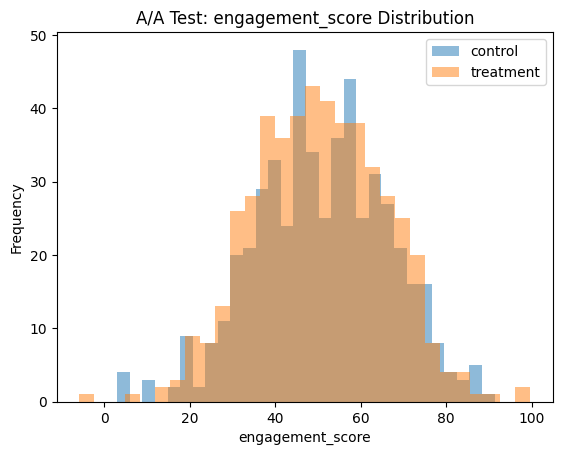

In [25]:
run_aa_testing_generalized(
    df=users,
    group_col='group',
    metric_col=test_config['outcome_metric_col'],
    group_labels=test_config['group_labels'],
    test_family=test_config['family'],
    variant=test_config.get('variant'),
    alpha=0.05
)


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="type-i-error-simulation"></a>

<h4>🎲 Type I Error Simulation</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<h5>🔁 Repeated A/A Tests</h5>

<p>
While a single A/A test helps detect obvious flaws in group assignment (like SRM or data leakage), it’s still a one-off check.  
To gain confidence in your randomization method, we simulate <strong>multiple A/A tests</strong> using the same logic:
</p>

<ul>
  <li>Each run reassigns users randomly into <code>control</code> and <code>treatment</code> (with no actual change)</li>
  <li>We then run the statistical test between groups for each simulation</li>
  <li>We track how often the test reports a <strong>false positive</strong> (p &lt; α), which estimates the <strong>Type I error rate</strong></li>
</ul>

<blockquote>
  In theory, if your setup is unbiased and α = 0.05, you'd expect about 5% of simulations to return a significant result — this validates your A/B framework isn’t "trigger-happy."
</blockquote>

<h5>📊 What this tells you:</h5>

<ul>
  <li>Too many significant p-values → your framework is too noisy (bad randomization, poor test choice)</li>
  <li>Near 5% = healthy noise level, expected by design</li>
</ul>

<p>This step is optional but highly recommended when you're:</p>
<ul>
  <li>Trying out a new randomization strategy</li>
  <li>Validating an internal experimentation framework</li>
  <li>Stress-testing your end-to-end pipeline</li>
</ul>

</details>


In [26]:
def simulate_aa_type1_error_rate(
    df,
    metric_col,
    group_labels,
    test_family,
    variant=None,
    runs=100,
    alpha=0.05,
    seed=42,
    verbose=False
):
    """
    Simulates repeated A/A tests to estimate empirical Type I error rate.

    Returns:
    - p_values: list of p-values from each simulation
    """
    np.random.seed(seed)
    p_values = []

    for i in range(runs):
        shuffled_df = df.copy()
        shuffled_df['group'] = np.random.choice(group_labels, size=len(df), replace=True)

        p = run_outcome_similarity_test(
            df=shuffled_df,
            group_col='group',
            metric_col=metric_col,
            test_family=test_family,
            variant=variant,
            group_labels=group_labels,
            alpha=alpha,
            verbose=False
        )

        if p is not None:
            p_values.append(p)

        if verbose:
            print(f"Run {i+1}: p = {p:.4f}")

    significant = sum(p < alpha for p in p_values)
    error_rate = significant / runs

    print(f"\n📈 Type I Error Rate Estimate: {significant}/{runs} = {error_rate:.2%}")

    # Interpretation Block
    print(f"""
            🧠 Summary Interpretation:
            We simulated {runs} A/A experiments using random group assignment (no actual treatment).

            Test: {test_family.upper()}{' (' + variant + ')' if variant else ''}
            Metric: {metric_col}
            Alpha: {alpha}

            False positives (p < α): {significant} / {runs}
            → Estimated Type I Error Rate: {error_rate:.2%}

            This is within expected range for α = {alpha}.
            → ✅ Test framework is behaving correctly — no bias or sensitivity inflation.
            """)

    plot_p_value_distribution(p_values, alpha=alpha)

    return p_values


In [27]:
def plot_p_value_distribution(p_values, alpha=0.05):
    plt.figure(figsize=(8, 4))
    plt.hist(p_values, bins=20, edgecolor='black', alpha=0.7)
    plt.axvline(x=alpha, color='red', linestyle='--', label=f"α = {alpha}")
    plt.title("P-value Distribution Across A/A Tests")
    plt.xlabel("P-value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()



📈 Type I Error Rate Estimate: 4/100 = 4.00%

            🧠 Summary Interpretation:
            We simulated 100 A/A experiments using random group assignment (no actual treatment).

            Test: T_TEST (independent)
            Metric: engagement_score
            Alpha: 0.05

            False positives (p < α): 4 / 100
            → Estimated Type I Error Rate: 4.00%

            This is within expected range for α = 0.05.
            → ✅ Test framework is behaving correctly — no bias or sensitivity inflation.
            


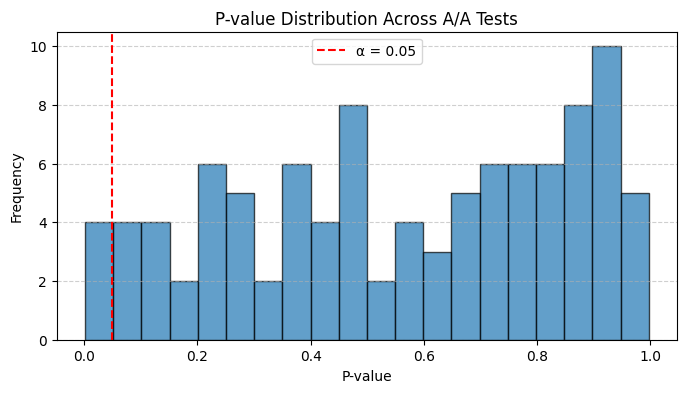

In [28]:
_ = simulate_aa_type1_error_rate(
    df=users,
    metric_col=test_config['outcome_metric_col'],
    group_labels=test_config['group_labels'],
    test_family=test_config['family'],
    variant=test_config.get('variant'),
    runs=100,
    alpha=0.05
)


[Back to the top](#table-of-contents)
___


<a id="power-analysis"></a>

<h1>⚡ Power Analysis</h1>

<details><summary><strong>📖 Click to Expand </strong></summary>

<p>Power analysis helps determine the <strong>minimum sample size</strong> required to detect a true effect with statistical confidence.</p>

<h5>Why It Matters:</h5>
<ul>
  <li>Avoids <strong>underpowered tests</strong> (risk of missing real effects)</li>
  <li>Balances tradeoffs between Sample size, Minimum Detectable Effect (MDE), Significance level (α), Statistical power (1 - β)</li>
</ul>

<h5>Key Inputs:</h5>
<table>
<thead>
<tr>
  <th>Parameter</th>
  <th>Meaning</th>
</tr>
</thead>
<tbody>
<tr>
  <td><strong>alpha (α)</strong></td>
  <td>Significance level (probability of false positive), e.g. 0.05</td>
</tr>
<tr>
  <td><strong>Power (1 - β)</strong></td>
  <td>Probability of detecting a true effect, e.g. 0.80 or 0.90</td>
</tr>
<tr>
  <td><strong>Baseline</strong></td>
  <td>Current outcome (e.g., 10% conversion, $50 revenue)</td>
</tr>
<tr>
  <td><strong>MDE</strong></td>
  <td>Minimum detectable effect — the smallest meaningful lift (e.g., +2% or +$5)</td>
</tr>
<tr>
  <td><strong>Std Dev</strong></td>
  <td>Standard deviation of the metric (for continuous outcomes)</td>
</tr>
<tr>
  <td><strong>Effect Size</strong></td>
  <td>Optional: Cohen's d (for t-tests) or f (for ANOVA)</td>
</tr>
<tr>
  <td><strong>Groups</strong></td>
  <td>Number of groups (relevant for ANOVA)</td>
</tr>
</tbody>
</table>

<p>This notebook automatically selects the correct formula based on <code>experiment_type</code> variable.</p>

</details>


<a id="setup-inputs--config-values"></a>

<h4>⚙️ Setup Inputs + Config Values</h4>

<details><summary><strong>📖 Click to Expand </strong></summary>

<p>These are the <strong>core experiment design parameters</strong> required for power analysis and statistical testing.</p>

<ul>
  <li><code>alpha</code>: Significance level — the <strong>tolerance for false positives</strong> (commonly set at 0.05).</li>
  <li><code>power</code>: Probability of detecting a true effect — typically <strong>0.80 or 0.90</strong>.</li>
  <li><code>group_labels</code>: The names of the experimental groups (e.g., <code>'control'</code>, <code>'treatment'</code>).</li>
  <li><code>metric_col</code>: Outcome metric column you're analyzing.</li>
  <li><code>test_family</code>: Chosen statistical test (e.g., <code>'t_test'</code>, <code>'z_test'</code>, <code>'chi_square'</code>) based on assumptions.</li>
  <li><code>variant</code>: Experimental design structure — <code>'independent'</code> or <code>'paired'</code>.</li>
</ul>

<p>These inputs drive sample size estimation, test choice, and downstream analysis logic.</p>

</details>


In [29]:
# Define Core Inputs

# Use values from your config or plug in manually
alpha = 0.05  # False positive tolerance (Type I error)
power = 0.80  # Statistical power (1 - Type II error)
group_labels = test_config['group_labels']
metric_col = test_config['outcome_metric_col']
test_family = test_config['family']
variant = test_config.get('variant')


<a id="baseline-from-data"></a>

<h4>📈 Baseline Estimation from Data</h4>

<details>
<summary><strong>📖 Click to Expand </strong></summary>

<p>Before we calculate required sample size, we need a <strong>baseline value</strong> from historical or current data.</p>

<ul>
  <li>For <strong>binary metrics</strong> (e.g., conversion), the baseline is the current <strong>conversion rate</strong>.</li>
  <li>For <strong>continuous metrics</strong> (e.g., revenue, engagement), we estimate the <strong>mean and standard deviation</strong> from the control group.</li>
  <li>These values help translate the <strong>Minimum Detectable Effect (MDE)</strong> into a usable <strong>effect size</strong>.</li>
</ul>

<blockquote>
  ⚠️ Be cautious with outliers or extreme skew when computing baselines — they directly influence sample size estimates.
</blockquote>

</details>


In [30]:
# 🧮 Data-Driven Baseline Metric

if test_family == 'z_test':
    # For binary outcome (e.g., conversion): baseline = conversion rate in data
    baseline_rate = users[metric_col].mean()
    print(f"📊 Baseline conversion rate: {baseline_rate:.2%}")

elif test_family in ['t_test', 'anova', 'non_parametric']:
    # For continuous metrics (e.g., revenue, engagement)
    control_data = users[users['group'] == group_labels[0]][metric_col]
    baseline_mean = control_data.mean()
    std_dev = control_data.std()
    print(f"📊 Control group mean: {baseline_mean:.2f}")
    print(f"📏 Control group std dev: {std_dev:.2f}")

else:
    baseline_rate = None
    std_dev = None


📊 Control group mean: 51.03
📏 Control group std dev: 15.61


<a id="minimum-detectable-effect"></a>

<h4>📈 Minimum Detectable Effect</h4>

<details>
  <summary><strong>📖 Click to Expand</strong></summary>

  🎯 <strong>Minimum Detectable Effect (MDE)</strong> is the smallest <strong>business-relevant difference</strong> you want your test to catch.

  <ul>
    <li>It reflects <strong>what matters</strong> — not what the data happens to show</li>
    <li>Drives required sample size:
      <ul>
        <li>Smaller MDE → larger sample</li>
        <li>Larger MDE → smaller sample</li>
      </ul>
    </li>
  </ul>

  🧠 <strong>Choose an MDE based on:</strong>
  <ul>
    <li>What level of uplift would justify launching the feature?</li>
    <li>What's a meaningful change in your metric — not just statistical noise?</li>
  </ul>

</details>


In [31]:
# Minimum Detectable Effect (MDE)
# This is NOT data-driven — it reflects the minimum improvement you care about detecting.
# It should be small enough to catch valuable changes, but large enough to avoid inflating sample size.

# Examples by Metric Type:
# - Binary       : 0.02 → detect a 2% lift in conversion rate (e.g., from 10% to 12%)
# - Categorical  : 0.05 → detect a 5% shift in plan preference (e.g., more users choosing 'premium' over 'basic')
# - Continuous   : 3.0  → detect a 3-point gain in engagement score (e.g., from 50 to 53 avg. score)

mde = 5  # Change this based on business relevance


<a id="required-sample-size"></a>

#### 📐 Required Sample Size

In [32]:
def calculate_power_sample_size(
    test_family,
    variant=None,
    alpha=0.05,
    power=0.80,
    baseline_rate=None,  # required for z-test
    mde=None,
    std_dev=None,
    effect_size=None,
    num_groups=2  # placeholder for future ANOVA support
):
    """
    Calculate required sample size per group based on test type and assumptions.

    Supported families:
    - 'z_test'              : Binary outcomes (proportions)
    - 't_test'              : Continuous outcomes (independent or paired)
    - 'non_parametric'      : Mann-Whitney (approximated as t-test)
    - 'anova'               : Not implemented (default to t-test)
    - 'chi_square'          : Categorical outcomes (not used in this version)
    """
    # -- Z-Test for Binary Proportions --
    if test_family == 'z_test':
        if baseline_rate is None or mde is None:
            raise ValueError("baseline_rate and mde are required for z-test (binary outcome).")

        z_alpha = stats.norm.ppf(1 - alpha / 2)
        z_beta = stats.norm.ppf(power)
        p1 = baseline_rate
        p2 = p1 + mde
        pooled_std = np.sqrt(2 * p1 * (1 - p1))

        n = ((z_alpha + z_beta) ** 2 * pooled_std ** 2) / (mde ** 2)
        return int(np.ceil(n))

    # -- T-Test for Continuous (Independent or Paired) --
    elif test_family in ['t_test', 'non_parametric', 'anova']:
        if effect_size is None:
            if std_dev is None or mde is None:
                raise ValueError("For continuous outcomes, provide either effect_size or both std_dev and mde.")
            effect_size = mde / std_dev  # Cohen's d

        if variant == 'independent':
            analysis = TTestIndPower()
        elif variant == 'paired':
            analysis = TTestPower()
        else:
            raise ValueError("variant must be 'independent' or 'paired' for t-test.")

        n = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
        return int(np.ceil(n))

    else:
        raise ValueError(f"❌ Unsupported test family: {test_family}")


In [33]:
required_sample_size = calculate_power_sample_size(
    test_family=test_family,
    variant=variant,
    alpha=alpha,
    power=power,
    baseline_rate=baseline_rate if test_family == 'z_test' else None,
    mde=mde,
    std_dev=std_dev if test_family in ['t_test', 'anova', 'non_parametric'] else None,
    effect_size=None,  # Let it compute internally via mde/std
    num_groups=2
)

test_config['required_sample_size'] = required_sample_size
print(f"✅ Required sample size per group: {required_sample_size}")
print(f"👥 Total sample size: {required_sample_size * 2}")

✅ Required sample size per group: 154
👥 Total sample size: 308


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="power-analysis-summary"></a>

#### 📊 Power Analysis Summary

In [34]:
def print_power_summary(
    test_family,
    variant,
    alpha,
    power,
    baseline_rate=None,
    mde=None,
    std_dev=None,
    required_sample_size=None
):
    print("📈 Power Analysis Summary")
    print(f"- Test: {test_family.upper()}{' (' + variant + ')' if variant else ''}")
    print(f"- Significance level (α): {alpha}")
    print(f"- Statistical power (1 - β): {power}")

    if test_family == 'z_test':
        print(f"- Baseline conversion rate: {baseline_rate:.2%}")
        print(f"- MDE: {mde:.2%}")
        print(f"\n✅ To detect a lift from {baseline_rate:.2%} to {(baseline_rate + mde):.2%},")
        print(f"you need {required_sample_size} users per group → total {required_sample_size * 2} users.")

    elif test_family == 't_test':
        print(f"- Std Dev (control group): {std_dev:.2f}")
        print(f"- MDE (mean difference): {mde}")
        print(f"- Cohen's d: {mde / std_dev:.2f}")
        print(f"\n✅ To detect a {mde}-unit lift in mean outcome,")
        print(f"you need {required_sample_size} users per group → total {required_sample_size * 2} users.")

    else:
        print("⚠️ Unsupported family for summary.")

print_power_summary(
    test_family=test_family,
    variant=variant,
    alpha=alpha,
    power=power,
    baseline_rate=baseline_rate if test_family == 'z_test' else None,
    mde=mde,
    std_dev=std_dev if test_family == 't_test' else None,
    required_sample_size=required_sample_size
)


📈 Power Analysis Summary
- Test: T_TEST (independent)
- Significance level (α): 0.05
- Statistical power (1 - β): 0.8
- Std Dev (control group): 15.61
- MDE (mean difference): 5
- Cohen's d: 0.32

✅ To detect a 5-unit lift in mean outcome,
you need 154 users per group → total 308 users.


[Back to the top](#table-of-contents)
___

<a id="ab-testing"></a>

<h1>🧪 A/B Testing</h1>

🔗 For test selection (e.g., Z-test, t-test), refer to [📖 Hypothesis Testing Notebook](https://ashrithssreddy.github.io/statistics-toolkit/Hypothesis_Testing/Hypothesis_Testing.html)

<details><summary><strong>📖 Click to Expand </strong></summary>

<h5>🧪 A/B Testing - Outcome Comparison</h5>

<p>This section compares the outcome metric between control and treatment groups using the appropriate statistical test based on the experiment type.</p>

<h5>📌 Metric Tracked:</h5>
<ul>
  <li><strong>Primary metric:</strong> Depends on use case:
    <ul>
      <li><strong>Binary:</strong> Conversion rate (clicked or not)</li>
      <li><strong>Continuous:</strong> Average engagement, revenue, time spent</li>
      <li><strong>Categorical:</strong> Plan type, user tier, etc.</li>
    </ul>
  </li>
  <li><strong>Unit of analysis:</strong> Unique user or unique observation</li>
</ul>

<h5>🔬 Outcome Analysis Steps:</h5>
<ul>
  <li>Choose the <strong>right statistical test</strong> based on <code>experiment_type</code>:
    <ul>
      <li><code>'binary'</code> → <strong>Z-test for proportions</strong></li>
      <li><code>'continuous_independent'</code> → <strong>Two-sample t-test</strong></li>
      <li><code>'continuous_paired'</code> → <strong>Paired t-test</strong></li>
      <li><code>'categorical'</code> → <strong>Chi-square test of independence</strong></li>
    </ul>
  </li>
  <li>Calculate test statistics, p-values, and confidence intervals</li>
  <li>Visualize the comparison to aid interpretation</li>
</ul>

</details>


In [35]:
def run_ab_test(
    df,
    group_col,
    metric_col,
    group_labels,
    test_family,
    variant=None,
    alpha=0.05
):
    """
    Runs the correct statistical test based on test_family + variant combo.

    Returns:
    - result dict with summary stats, test used, p-value, and test-specific values
    """
    group1, group2 = group_labels
    data1 = df[df[group_col] == group1][metric_col]
    data2 = df[df[group_col] == group2][metric_col]

    result = {
        'test_family': test_family,
        'variant': variant,
        'group_labels': group_labels,
        'alpha': alpha,
        'summary': {}
    }

    # --- Summary Stats ---
    result['summary'][group1] = {
        'n': len(data1),
        'mean': data1.mean(),
        'std': data1.std() if test_family in ['t_test', 'non_parametric'] else None,
        'sum': data1.sum() if test_family == 'z_test' else None
    }
    result['summary'][group2] = {
        'n': len(data2),
        'mean': data2.mean(),
        'std': data2.std() if test_family in ['t_test', 'non_parametric'] else None,
        'sum': data2.sum() if test_family == 'z_test' else None
    }

    # --- Binary Proportions (Z-Test) ---
    if test_family == 'z_test':
        x1, n1 = data1.sum(), len(data1)
        x2, n2 = data2.sum(), len(data2)
        p_pooled = (x1 + x2) / (n1 + n2)
        se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
        z_stat = (x2/n2 - x1/n1) / se
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        result.update({'test': 'z-test for proportions', 'z_stat': z_stat, 'p_value': p_value})

    # --- Continuous (T-Test) ---
    elif test_family == 't_test':
        if variant == 'independent':
            t_stat, p_value = stats.ttest_ind(data1, data2, equal_var=False)
            result.update({'test': 'independent t-test', 't_stat': t_stat, 'p_value': p_value})
        elif variant == 'paired':
            if len(data1) != len(data2):
                raise ValueError("Paired test requires equal-length matching samples.")
            t_stat, p_value = stats.ttest_rel(data1, data2)
            result.update({'test': 'paired t-test', 't_stat': t_stat, 'p_value': p_value})
        else:
            raise ValueError("Missing or invalid variant for t-test.")

    # --- Continuous (Non-parametric) ---
    elif test_family == 'non_parametric':
        u_stat, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        result.update({'test': 'Mann-Whitney U Test', 'u_stat': u_stat, 'p_value': p_value})

    # --- Categorical (Chi-square) ---
    elif test_family == 'chi_square':
        contingency = pd.crosstab(df[group_col], df[metric_col])
        chi2, p_value, _, _ = stats.chi2_contingency(contingency)
        result.update({'test': 'chi-square test', 'chi2_stat': chi2, 'p_value': p_value})

    else:
        raise ValueError(f"❌ Unsupported test_family: {test_family}")

    return result


In [36]:
result = run_ab_test(
    df=users,
    group_col='group',
    metric_col=test_config['outcome_metric_col'],
    group_labels=test_config['group_labels'],
    test_family=test_config['family'],
    variant=test_config.get('variant'),
    alpha=0.05
)
result

{'test_family': 't_test',
 'variant': 'independent',
 'group_labels': ('control', 'treatment'),
 'alpha': 0.05,
 'summary': {'control': {'n': 510,
   'mean': 51.02515924585304,
   'std': 15.60949221088591,
   'sum': None},
  'treatment': {'n': 490,
   'mean': 50.31059463655223,
   'std': 15.354069556161138,
   'sum': None}},
 'test': 'independent t-test',
 't_stat': 0.7297273039756266,
 'p_value': 0.4657282187278262}

[Back to the top](#table-of-contents)
___


<a id="results"></a>

# 📉 Results

<a id="summaries"></a>
#### 🧾 Summaries

In [37]:
def summarize_ab_test_result(result):
    """
    Prints A/B test results summary with statistical test outputs and lift analysis.
    """
    test_family = result['test_family']
    variant = result.get('variant')
    group1, group2 = result['group_labels']
    p_value = result.get('p_value')
    alpha = result.get('alpha', 0.05)

    print("\n" + "="*45)
    print(f"🧪 A/B Test Result Summary [{test_family.upper()}]")
    print("="*45)

    # ---- Hypothesis Test Output ----
    print("\n📊 Hypothesis Test Result")
    print(f"Test used: {result.get('test', 'N/A')}")
    if 'z_stat' in result:
        print(f"Z-statistic: {result['z_stat']:.4f}")
    elif 't_stat' in result:
        print(f"T-statistic: {result['t_stat']:.4f}")
    elif 'chi2_stat' in result:
        print(f"Chi2-statistic: {result['chi2_stat']:.4f}")
    elif 'u_stat' in result:
        print(f"U-statistic: {result['u_stat']:.4f}")

    if p_value is not None:
        print(f"P-value    : {p_value:.4f}")
        print("✅ Statistically significant difference detected." if p_value < alpha else "🚫 No significant difference detected.")
    else:
        print("⚠️ P-value not found.")

    # ---- Summary Table ----
    print("\n📋 Group Summary:\n")
    display(pd.DataFrame(result['summary']).T)

    # ---- Lift Analysis (for Z-test or T-test (independent)) ----
    if test_family in ['z_test', 't_test'] and (variant == 'independent' or test_family == 'z_test'):
        group1_mean = result['summary'][group1]['mean']
        group2_mean = result['summary'][group2]['mean']
        lift = group2_mean - group1_mean
        pct_lift = lift / group1_mean if group1_mean else np.nan

        print("\n📈 Lift Analysis")
        print(f"- Absolute Lift   : {lift:.4f}")
        print(f"- Percentage Lift : {pct_lift:.2%}")

        try:
            n1 = result['summary'][group1]['n']
            n2 = result['summary'][group2]['n']

            if test_family == 'z_test':
                se = np.sqrt(group1_mean * (1 - group1_mean) / n1 + group2_mean * (1 - group2_mean) / n2)
            else:
                sd1 = result['summary'][group1].get('std')
                sd2 = result['summary'][group2].get('std')
                se = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)

            z = 1.96
            ci_low = lift - z * se
            ci_high = lift + z * se
            print(f"- 95% CI for Lift : [{ci_low:.4f}, {ci_high:.4f}]")
        except Exception as e:
            print(f"⚠️ Could not compute confidence interval: {e}")

    print("="*45 + "\n")


In [38]:
summarize_ab_test_result(result)


🧪 A/B Test Result Summary [T_TEST]

📊 Hypothesis Test Result
Test used: independent t-test
T-statistic: 0.7297
P-value    : 0.4657
🚫 No significant difference detected.

📋 Group Summary:



,n,mean,std,sum
control,510.0,51.025159,15.609492,NaN
treatment,490.0,50.310595,15.354070,NaN



📈 Lift Analysis
- Absolute Lift   : -0.7146
- Percentage Lift : -1.40%
- 95% CI for Lift : [-2.6338, 1.2047]



<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="results-visualization"></a>

#### 📊 Visualization

In [39]:
def plot_ab_test_results(result):
    """
    Plots A/B test results by group mean or distribution depending on test family.
    """
    test_family = result['test_family']
    variant = result.get('variant')
    group1, group2 = result['group_labels']

    print("\n📊 Visualization:")

    if test_family in ['z_test', 't_test', 'non_parametric']:
        labels = [group1, group2]
        values = [result['summary'][group1]['mean'], result['summary'][group2]['mean']]
        plt.bar(labels, values, color=['gray', 'skyblue'])

        for i, val in enumerate(values):
            label = f"{val:.2%}" if test_family == 'z_test' else f"{val:.2f}"
            plt.text(i, val + 0.01, label, ha='center')

        ylabel = "Conversion Rate" if test_family == 'z_test' else "Average Value"
        plt.ylabel(ylabel)
        plt.title(f"{ylabel} by Group")
        plt.ylim(0, max(values) * 1.2)
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()

    elif test_family == 'chi_square':
        dist = pd.DataFrame(result['summary'])
        dist.T.plot(kind='bar', stacked=True)
        plt.title(f"Categorical Distribution by Group")
        plt.ylabel("Proportion")
        plt.xlabel("Group")
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.show()



📊 Visualization:


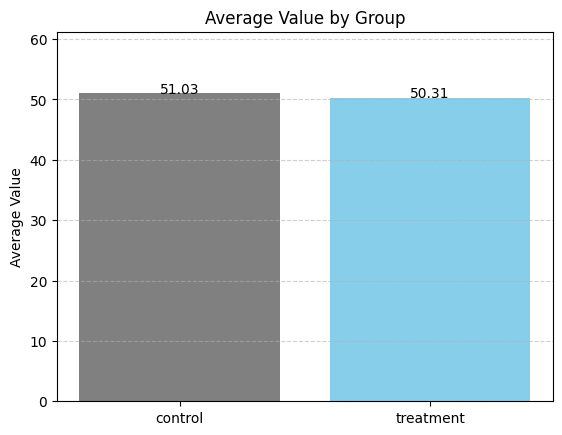

In [40]:
plot_ab_test_results(result)

<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="confidence-intervals"></a>

<h4>🎯 95% Confidence Intervals<br><small>for <code>outcome in groups</code></small></h4>

<details><summary><strong>📖 Click to Expand </strong></summary>

<ul>
  <li>The 95% confidence interval gives a range in which we expect the <strong>true conversion rate</strong> to fall for each group.</li>
  <li>If the confidence intervals <strong>do not overlap</strong>, it's strong evidence that the difference is statistically significant.</li>
  <li>If they <strong>do overlap</strong>, it doesn't guarantee insignificance — you still need the p-value to decide — but it suggests caution when interpreting lift.</li>
</ul>

</details>


In [41]:
def plot_confidence_intervals(result, z=1.96):
    """
    Plot 95% confidence intervals for group means (conversion rate or continuous).
    """
    test_family = result['test_family']
    variant = result.get('variant')
    group1, group2 = result['group_labels']
    summary = result['summary']

    if test_family not in ['z_test', 't_test']:
        print(f"⚠️ CI plotting not supported for test family: {test_family}")
        return
    if test_family == 't_test' and variant != 'independent':
        print(f"⚠️ CI plotting only supported for independent t-tests.")
        return

    p1, p2 = summary[group1]['mean'], summary[group2]['mean']
    n1, n2 = summary[group1]['n'], summary[group2]['n']

    if test_family == 'z_test':
        se1 = np.sqrt(p1 * (1 - p1) / n1)
        se2 = np.sqrt(p2 * (1 - p2) / n2)
        ylabel = "Conversion Rate"
    else:
        sd1 = summary[group1]['std']
        sd2 = summary[group2]['std']
        se1 = sd1 / np.sqrt(n1)
        se2 = sd2 / np.sqrt(n2)
        ylabel = "Mean Outcome"

    ci1 = (p1 - z * se1, p1 + z * se1)
    ci2 = (p2 - z * se2, p2 + z * se2)

    plt.errorbar([group1, group2],
                 [p1, p2],
                 yerr=[[p1 - ci1[0], p2 - ci2[0]], [ci1[1] - p1, ci2[1] - p2]],
                 fmt='o', capsize=10, color='black')
    plt.ylabel(ylabel)
    plt.title(f"{ylabel} with 95% Confidence Intervals")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


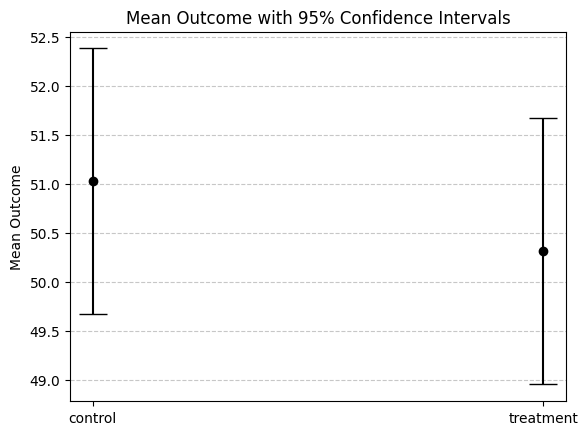

In [42]:
plot_confidence_intervals(result)


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="lift-analysis"></a>

<h4>📈 Lift Analysis<br><small>AKA 95% Confidence Intervals for (difference in outcomes)</small></h4>

<details><summary><strong>📖 Click to Expand </strong></summary>

<p>This confidence interval helps quantify uncertainty around the observed <strong>lift</strong> between treatment and control groups. It answers:</p>

<ul>
  <li><em>How large is the difference between groups?</em></li>
  <li><em>How confident are we in this lift estimate?</em></li>
</ul>

<p>
We compute a 95% CI for the difference in means (or proportions), not just for each group. If this interval <strong>does not include 0</strong>, we can reasonably trust there's a true difference.  
If it <strong>does include 0</strong>, the observed difference might be due to random chance.
</p>

<p>
This complements the p-value — while p-values tell us <em>if</em> the difference is significant, <strong>CIs tell us how big the effect is, and how uncertain we are.</strong>
</p>

</details>


In [43]:
def compute_lift_confidence_interval(result):
    """
    Compute CI for lift in binary or continuous-independent tests.
    """
    test_family = result['test_family']
    variant = result.get('variant')
    group1, group2 = result['group_labels']
    alpha = result.get('alpha', 0.05)
    z = 1.96

    print("\n" + "="*45)
    print(f"📈 95% CI for Difference in Outcome [{test_family}]")
    print("="*45)

    if test_family == 'z_test' or (test_family == 't_test' and variant == 'independent'):
        m1 = result['summary'][group1]['mean']
        m2 = result['summary'][group2]['mean']
        lift = m2 - m1
        n1 = result['summary'][group1]['n']
        n2 = result['summary'][group2]['n']

        if test_family == 'z_test':
            se = np.sqrt(m1 * (1 - m1) / n1 + m2 * (1 - m2) / n2)
        else:
            sd1 = result['summary'][group1]['std']
            sd2 = result['summary'][group2]['std']
            se = np.sqrt((sd1 ** 2) / n1 + (sd2 ** 2) / n2)

        ci_low = lift - z * se
        ci_high = lift + z * se

        print(f"- Absolute Lift         : {lift:.4f}")
        print(f"- 95% Confidence Interval: [{ci_low:.4f}, {ci_high:.4f}]")

        if ci_low > 0:
            print("✅ Likely positive impact (CI > 0)")
        elif ci_high < 0:
            print("🚫 Likely negative impact (CI < 0)")
        else:
            print("🤷 CI includes 0 — not statistically significant.")

    elif test_family == 't_test' and variant == 'paired':
        print("- Paired test: CI already accounted for in test logic.")

    elif test_family == 'chi_square':
        print("- Categorical test: per-category lift analysis required (not implemented).")

    print("="*45 + "\n")


In [44]:
compute_lift_confidence_interval(result)


📈 95% CI for Difference in Outcome [t_test]
- Absolute Lift         : -0.7146
- 95% Confidence Interval: [-2.6338, 1.2047]
🤷 CI includes 0 — not statistically significant.



<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="final-conclusion"></a>

#### ✅ Final Conclusion


In [45]:
def print_final_ab_test_summary(result):
    """
    Final wrap-up of results with summary stats and verdict.
    """
    test_family = result['test_family']
    variant = result.get('variant')
    group1, group2 = result['group_labels']
    p_value = result.get('p_value')
    alpha = result.get('alpha', 0.05)

    print("="*40)
    print("          📊 FINAL A/B TEST SUMMARY")
    print("="*40)

    if test_family == 'z_test' or (test_family == 't_test' and variant == 'independent'):
        mean1 = result['summary'][group1]['mean']
        mean2 = result['summary'][group2]['mean']
        lift = mean2 - mean1
        pct_lift = lift / mean1 if mean1 else np.nan

        label = "Conversion rate" if test_family == 'z_test' else "Avg outcome"
        test_name = result.get("test", "A/B test")

        print(f"👥  {group1.capitalize()} {label:<20}:  {mean1:.4f}")
        print(f"🧪  {group2.capitalize()} {label:<20}:  {mean2:.4f}")
        print(f"📈  Absolute lift              :  {lift:.4f}")
        print(f"📊  Percentage lift            :  {pct_lift:.2%}")
        print(f"🧪  P-value (from {test_name}) :  {p_value:.4f}")

    elif test_family == 't_test' and variant == 'paired':
        print("🧪 Paired T-Test was used to compare within-user outcomes.")
        print(f"🧪 P-value: {p_value:.4f}")

    elif test_family == 'chi_square':
        print("🧪 Chi-square test was used to compare categorical distributions.")
        print(f"🧪 P-value: {p_value:.4f}")

    else:
        print("⚠️ Unsupported test type.")

    print("-" * 40)

    if p_value is not None:
        if p_value < alpha:
            print("✅ RESULT: Statistically significant difference detected.")
        else:
            print("❌ RESULT: No statistically significant difference detected.")
    else:
        print("⚠️ No p-value available.")

    print("="*40 + "\n")


In [46]:
print_final_ab_test_summary(result)

          📊 FINAL A/B TEST SUMMARY
👥  Control Avg outcome         :  51.0252
🧪  Treatment Avg outcome         :  50.3106
📈  Absolute lift              :  -0.7146
📊  Percentage lift            :  -1.40%
🧪  P-value (from independent t-test) :  0.4657
----------------------------------------
❌ RESULT: No statistically significant difference detected.



[Back to the top](#table-of-contents)
___


<a id="how-long"></a>
<h1>⏱️ How Long</h1>
<h4>to run the test?</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>The duration of an A/B test depends on how quickly you reach the required sample size per group, as estimated during your power analysis.</p>

<h5>✅ Key Inputs</h5>
<ul>
  <li>Daily volume of eligible observations (users, sessions, or orders — depends on your unit of analysis)</li>
  <li>Required sample size per group (from power analysis)</li>
  <li>Traffic split ratio (e.g., 50/50, 10/90, 33/33/33)</li>
</ul>

<h5>🧮 Formula</h5>
<blockquote>
  Test Duration (in days) =<br>
  Required Sample Size per Group ÷ (Daily Eligible Observations × Group Split Proportion)
</blockquote>

<p>This ensures the experiment runs long enough to detect the expected effect with the desired confidence and power.</p>

<h5>💡 Planning Tips</h5>
<ol>
  <li>Estimate required sample size using power analysis (based on effect size, baseline, alpha, and power)</li>
  <li>Understand your traffic: 
    <ul>
      <li>What’s your average daily eligible traffic?</li>
      <li>What unit of analysis is used (user, session, impression)?</li>
    </ul>
  </li>
  <li>Apply group split:
    <ul>
      <li>e.g., for a 50/50 A/B test, each group gets 50% of traffic</li>
    </ul>
  </li>
  <li>Estimate days using the formula above.</li>
</ol>

<h5>🧠 Real-World Considerations</h5>
<ul>
  <li><strong>✅ Ramp-Up Period</strong><br>
    Gradually increase traffic exposure: 5% → 25% → 50% → full traffic.<br>
    Helps catch bugs, stability issues, and confounding edge cases early.
  </li>
  <li><strong>✅ Cool-Down Buffer</strong><br>
    Avoid ending tests on weekends, holidays, or during unusual traffic spikes.<br>
    Add buffer days so your conclusions aren’t skewed by anomalies.
  </li>
  <li><strong>✅ Trust Checks Before Analysis</strong>
    <ul>
      <li>A/A testing to verify setup</li>
      <li>SRM checks to confirm user distribution</li>
      <li>Monitor guardrail metrics (e.g., bounce rate, latency, load time)</li>
    </ul>
  </li>
</ul>

<h5>🗣️ Common Practitioner Advice</h5>
<blockquote>
  “We calculate sample size using power analysis, then divide by daily traffic per group. But we always factor in buffer days — for ramp-up, trust checks, and stability. Better safe than sorry.”
  <br><br>
  “Power analysis is the starting point. But we don’t blindly stop when we hit N. We monitor confidence intervals, metric stability, and coverage to make sure we’re making decisions the business can trust.”
</blockquote>

</details>


In [47]:
def estimate_test_duration(
    required_sample_size_per_group,
    daily_eligible_users,
    allocation_ratios=(0.5, 0.5),
    buffer_days=2,
    test_family=None  # renamed from experiment_type
):
    """
    Estimate test duration based on sample size, traffic, and allocation.

    Parameters:
    - required_sample_size_per_group: int
    - daily_eligible_users: int — total incoming traffic per day
    - allocation_ratios: tuple — traffic share per group (e.g., 50/50)
    - buffer_days: int — extra time for ramp-up or anomalies
    - test_family: str — optional metadata for clarity

    Returns:
    - dict with group durations and total estimated runtime
    """
    group_durations = []
    for alloc in allocation_ratios:
        users_per_day = daily_eligible_users * alloc
        days = required_sample_size_per_group / users_per_day if users_per_day else float('inf')
        group_durations.append(np.ceil(days))

    longest_group_runtime = int(max(group_durations))
    total_with_buffer = longest_group_runtime + buffer_days

    print("\n🧮 Estimated Test Duration")
    if test_family:
        print(f"- Test family               : {test_family}")
    print(f"- Required sample per group : {required_sample_size_per_group}")
    print(f"- Daily eligible traffic    : {daily_eligible_users}")
    print(f"- Allocation ratio          : {allocation_ratios}")
    print(f"- Longest group runtime     : {longest_group_runtime} days")
    print(f"- Buffer days               : {buffer_days}")
    print(f"✅ Total estimated duration : {total_with_buffer} days\n")

    return {
        'test_family': test_family,
        'per_group_days': group_durations,
        'longest_group_runtime': longest_group_runtime,
        'recommended_total_duration': total_with_buffer
    }


In [48]:
daily_eligible_users = 1000
allocation_ratios = (0.5, 0.5)
buffer_days = 2

test_duration_result = estimate_test_duration(
    required_sample_size_per_group=test_config['required_sample_size'],
    daily_eligible_users=daily_eligible_users,
    allocation_ratios=allocation_ratios,
    buffer_days=buffer_days,
    test_family=test_config['family']
)
test_duration_result


🧮 Estimated Test Duration
- Test family               : t_test
- Required sample per group : 154
- Daily eligible traffic    : 1000
- Allocation ratio          : (0.5, 0.5)
- Longest group runtime     : 1 days
- Buffer days               : 2
✅ Total estimated duration : 3 days



{'test_family': 't_test',
 'per_group_days': [1.0, 1.0],
 'longest_group_runtime': 1,
 'recommended_total_duration': 3}

<a id="monitoring-dashboard-components"></a>

<h4>🧭 Monitoring Dashboard Components</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>


<ul>
  <li><strong>Overall Test Health</strong>
    <ul>
      <li>Start/end date, traffic ramp-up %, time remaining</li>
      <li>SRM (Sample Ratio Mismatch) indicator</li>
      <li>P-value and effect size summary (updated daily)</li>
    </ul>
  </li>
  <li><strong>Primary Metric Tracking</strong>
    <ul>
      <li>Daily trends for primary outcome (conversion, revenue, etc.)</li>
      <li>Cumulative lift + confidence intervals</li>
      <li>Statistical significance tracker (p-value, test stat)</li>
    </ul>
  </li>
  <li><strong>Guardrail Metrics</strong>
    <ul>
      <li>Bounce rate, load time, checkout errors, etc.</li>
      <li>Alert thresholds (e.g., +10% increase in latency)</li>
      <li>Trend vs baseline and prior experiments</li>
    </ul>
  </li>
  <li><strong>Segment Drilldowns</strong>
    <ul>
      <li>Platform (iOS vs Android), geography, user tier</li>
      <li>Detect heterogeneous treatment effects</li>
      <li>Option to toggle test results per segment</li>
    </ul>
  </li>
  <li><strong>Cohort Coverage</strong>
    <ul>
      <li>Total users assigned vs eligible</li>
      <li>Daily inclusion and exclusion trends</li>
      <li>Debugging filters (e.g., why user X didn’t get assigned)</li>
    </ul>
  </li>
  <li><strong>Variance & Stability Checks</strong>
    <ul>
      <li>Volatility of key metrics</li>
      <li>Pre vs post baseline comparisons</li>
      <li>Funnel conversion variance analysis</li>
    </ul>
  </li>
  <li><strong>Notes & Annotations</strong>
    <ul>
      <li>Manual tagging of major incidents (e.g., bug fix deployed, pricing change)</li>
      <li>Timeline of changes affecting experiment interpretation</li>
    </ul>
  </li>
</ul>

</details>


[Back to the top](#table-of-contents)
___


<a id="post-hoc-analysis"></a>

<h1>🔍 Post Hoc Analysis</h1>

<details><summary><strong>📖 Click to Expand</strong></summary>

<blockquote>
  After statistical significance, post-hoc analysis helps <strong>connect results to business confidence</strong>.<br>
  It's not just <em>did it work</em> — but <em>how, for whom, and at what cost or benefit?</em>
</blockquote>

<p><strong>🧠 Why Post Hoc Analysis Matters</strong></p>
<ul>
  <li>Segments may <strong>respond differently</strong> — average lift may hide underperformance in subgroups</li>
  <li>Guardrails may show <strong>collateral damage</strong> (e.g., slower load time, higher churn)</li>
  <li>Stakeholders need <strong>impact translation</strong> — what does this mean in revenue, retention, or strategy?</li>
</ul>

<p><strong>🔎 Typical Post Hoc Questions</strong></p>
<ul>
  <li><strong>Segment Lift</strong>
    <ul>
      <li>Did certain platforms, geos, cohorts, or user types benefit more?</li>
      <li>Any negative lift in high-value user segments?</li>
    </ul>
  </li>
  <li><strong>Guardrail Checks</strong>
    <ul>
      <li>Did the treatment impact non-primary metrics (e.g., latency, engagement, bounce rate)?</li>
      <li>Were alert thresholds breached?</li>
    </ul>
  </li>
  <li><strong>Business Impact Simulation</strong>
    <ul>
      <li>How does the observed lift scale to 100% of eligible users?</li>
      <li>What’s the projected change in conversions, revenue, or user satisfaction?</li>
    </ul>
  </li>
  <li><strong>Edge Case Discovery</strong>
    <ul>
      <li>Any bugs, instrumentation gaps, or unexpected usage patterns?</li>
      <li>Did any user types get excluded disproportionately?</li>
    </ul>
  </li>
</ul>

<p><strong>📊 What to Report</strong></p>

<table>
  <thead>
    <tr>
      <th>Area</th>
      <th>What to Show</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Segment Analysis</td>
      <td>Table or chart showing lift per segment, sorted by effect size or risk</td>
    </tr>
    <tr>
      <td>Guardrail Metrics</td>
      <td>Summary table of guardrails vs baseline, with thresholds or annotations</td>
    </tr>
    <tr>
      <td>Revenue Simulation</td>
      <td>Projected uplift × traffic volume × conversion = business impact</td>
    </tr>
    <tr>
      <td>Confidence Range</td>
      <td>95% CI for key metrics per segment (wherever possible)</td>
    </tr>
    <tr>
      <td>Rollout Readiness</td>
      <td>Any blockers, mitigations, or next steps if full rollout is considered</td>
    </tr>
  </tbody>
</table>

<p><strong>💡 Pro Tip</strong><br>
Even if your p-value says “yes,” <strong>business rollout is a risk-based decision</strong>.<br>
Post-hoc analysis is where <strong>statistical rigor meets product judgment</strong>.
</p>

</details>


<a id="segmented-lift"></a>

<h4>🧩 Segmented Lift</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Segmented lift tells us <strong>how different user segments responded</strong> to the treatment.</p>

<p><strong>Why It Matters:</strong></p>
<ul>
  <li><strong>Uncovers hidden heterogeneity</strong> — The overall average might mask variation across platforms, geographies, or user tiers.</li>
  <li><strong>Identifies high-risk or high-reward cohorts</strong> — Some segments might benefit more, while others could be negatively impacted.</li>
  <li><strong>Guides rollout and targeting decisions</strong> — Helps decide where to prioritize feature exposure, or where to mitigate risk.</li>
</ul>

<p><strong>Typical Segments:</strong></p>
<ul>
  <li>Device type (e.g., mobile vs desktop)</li>
  <li>Region (e.g., North vs South)</li>
  <li>User lifecycle (e.g., new vs returning)</li>
  <li>Platform (e.g., iOS vs Android)</li>
</ul>

<blockquote>
  <em>"Segmentation answers <strong>who is benefiting (or suffering)</strong> — not just <strong>whether it worked on average.</strong>"</em>
</blockquote>

</details>


In [49]:
def visualize_segment_lift(df_segment, segment_col):
    """
    Plots horizontal bar chart of mean lift per segment (Treatment - Control).
    """
    df_viz = df_segment.dropna(subset=['lift']).sort_values(by='lift', ascending=False)
    if df_viz.empty:
        print(f"⚠️ No lift data to visualize for '{segment_col}'\n")
        return

    plt.figure(figsize=(8, 0.4 * len(df_viz) + 2))
    bars = plt.barh(df_viz[segment_col], df_viz['lift'], color='skyblue')
    for bar, val in zip(bars, df_viz['lift']):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{val:.2f}", va='center', ha='left', fontsize=9)
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"Lift from Control to Treatment by {segment_col}")
    plt.xlabel("Mean Difference (Treatment – Control)")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [50]:
def analyze_segment_lift(
    df,
    test_config,
    segment_cols=['platform', 'device_type', 'user_tier', 'region'],
    min_count_per_group=30,
    visualize=True
):
    """
    Post-hoc lift analysis per segment (e.g., by platform or region).
    """

    group_col = 'group'
    group1, group2 = test_config['group_labels']
    metric_col = test_config['outcome_metric_col']
    outcome_type = test_config['outcome_metric_datatype']
    variant = test_config['variant']
    test_family = test_config['family']

    for segment in segment_cols:
        print(f"\n🔎 Segmenting by: {segment}")
        seg_data = []

        for val in df[segment].dropna().unique():
            subset = df[df[segment] == val]
            g1 = subset[subset[group_col] == group1][metric_col]
            g2 = subset[subset[group_col] == group2][metric_col]

            if len(g1) < min_count_per_group or len(g2) < min_count_per_group:
                print(f"⚠️ Skipping '{val}' under '{segment}' — too few users.")
                continue

            lift = g2.mean() - g1.mean()
            p_value = None

            if test_family == 'z_test':
                # Binary: z-test on proportions
                p1, n1 = g1.mean(), len(g1)
                p2, n2 = g2.mean(), len(g2)
                pooled_p = (g1.sum() + g2.sum()) / (n1 + n2)
                se = np.sqrt(pooled_p * (1 - pooled_p) * (1/n1 + 1/n2))
                p_value = 2 * (1 - stats.norm.cdf(abs((p2 - p1) / se)))

            elif test_family == 't_test':
                if variant == 'independent':
                    _, p_value = stats.ttest_ind(g1, g2)
                elif variant == 'paired':
                    print(f"⚠️ Paired test not supported in segmented lift — skipped '{val}' under '{segment}'.")
                    lift, p_value = np.nan, None

            elif test_family == 'chi_square':
                print(f"⚠️ Categorical data — lift not defined for '{val}' in '{segment}'.")
                lift, p_value = np.nan, None

            seg_data.append({
                segment: val,
                'count_control': len(g1),
                'count_treatment': len(g2),
                'mean_control': g1.mean(),
                'mean_treatment': g2.mean(),
                'std_control': g1.std(),
                'std_treatment': g2.std(),
                'lift': lift,
                'p_value_lift': p_value
            })

        df_segment = pd.DataFrame(seg_data)
        display(df_segment)

        if visualize:
            visualize_segment_lift(df_segment, segment)



🔎 Segmenting by: platform


,platform,count_control,count_treatment,mean_control,mean_treatment,std_control,std_treatment,lift,p_value_lift
0,iOS,306,283,51.473511,51.038554,15.720604,15.505342,-0.434958,0.735711
1,Android,204,207,50.352631,49.315366,15.455377,15.125414,-1.037265,0.492071


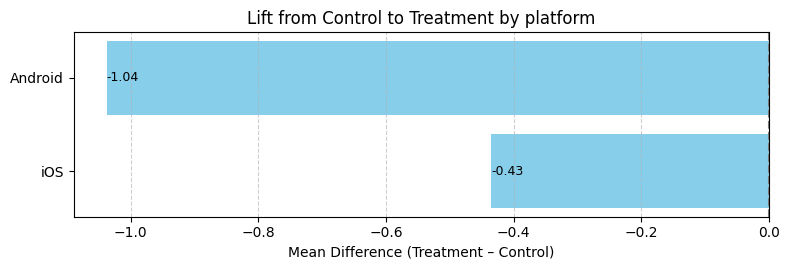


🔎 Segmenting by: device_type


,device_type,count_control,count_treatment,mean_control,mean_treatment,std_control,std_treatment,lift,p_value_lift
0,mobile,343,346,50.996739,50.737705,15.483445,15.166347,-0.259034,0.824508
1,desktop,167,144,51.083532,49.284344,15.912052,15.802427,-1.799188,0.319324


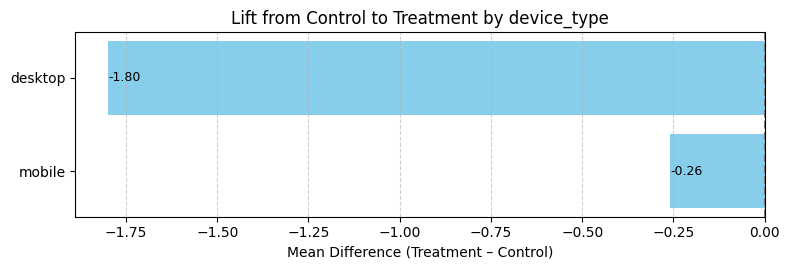


🔎 Segmenting by: user_tier


,user_tier,count_control,count_treatment,mean_control,mean_treatment,std_control,std_treatment,lift,p_value_lift
0,new,188,192,50.270166,52.095652,15.670024,15.297974,1.825486,0.251242
1,returning,322,298,51.465963,49.160490,15.581513,15.305550,-2.305472,0.063864


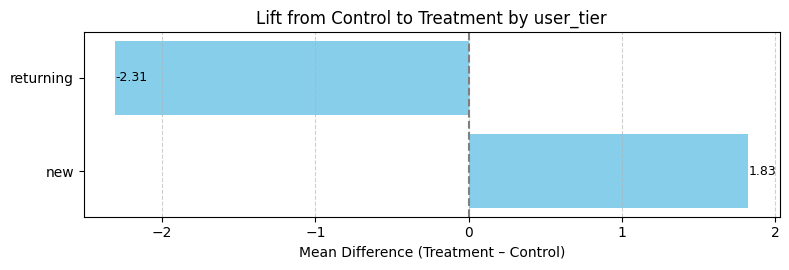


🔎 Segmenting by: region


,region,count_control,count_treatment,mean_control,mean_treatment,std_control,std_treatment,lift,p_value_lift
0,North,135,120,51.205860,51.554078,15.118047,15.206938,0.348218,0.854882
1,South,147,113,50.736052,50.185396,16.563319,15.340048,-0.550655,0.784045
2,West,106,126,50.974336,50.275715,13.928319,15.292805,-0.698620,0.718471
3,East,122,131,51.217713,49.313070,16.501732,15.653598,-1.904643,0.347038


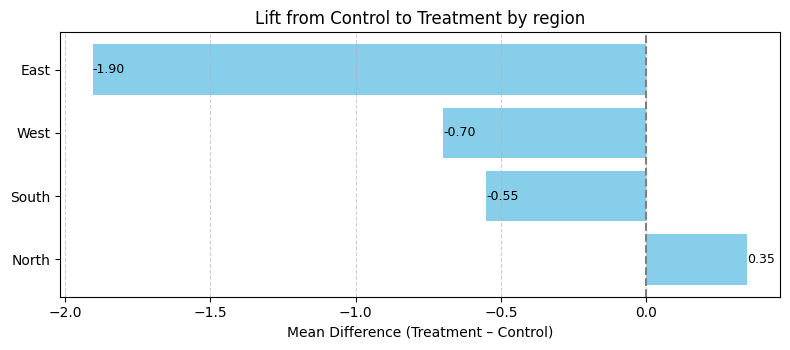

In [51]:
analyze_segment_lift(
    df=users,
    test_config=test_config,
    segment_cols=['platform', 'device_type', 'user_tier', 'region'],
    min_count_per_group=30,
    visualize=True
)


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="guardrail-metrics"></a>

<h4>🚦 Guardrail Metrics</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Guardrail metrics are <strong>non-primary metrics</strong> tracked during an experiment to ensure the feature doesn't create <strong>unintended negative consequences</strong>.</p>

<p>We monitor them alongside the main success metric to:</p>
<ul>
  <li>📉 Catch regressions in user behavior or system performance</li>
  <li>🔍 Detect trade-offs (e.g., conversion ↑ but bounce rate ↑ too)</li>
  <li>🛑 Block rollouts if a feature does more harm than good</li>
</ul>

<h6>🧪 How We Check</h6>
<ul>
  <li>Run <strong>statistical tests</strong> on each guardrail metric just like we do for the primary metric</li>
  <li>Use the <strong>same experiment type</strong> (binary, continuous, etc.) for evaluation</li>
  <li>Report <strong>p-values and lift</strong> to assess significance and direction</li>
  <li>Focus more on <strong>risk detection</strong> than optimization</li>
</ul>

<h6>📊 Common Guardrail Metrics</h6>
<table>
  <tr><th>Type</th><th>Examples</th></tr>
  <tr><td><strong>UX Health</strong></td><td>Bounce Rate, Session Length, Engagement</td></tr>
  <tr><td><strong>Performance</strong></td><td>Page Load Time, API Latency, CPU Usage</td></tr>
  <tr><td><strong>Reliability</strong></td><td>Error Rate, Crash Rate, Timeout Errors</td></tr>
  <tr><td><strong>Behavioral</strong></td><td>Scroll Depth, Page Views per Session</td></tr>
</table>

<h6>✅ When to Act</h6>
<ul>
  <li>If the <strong>treatment significantly worsens</strong> a guardrail metric → investigate</li>
  <li>If the <strong>primary metric improves</strong> but <strong>guardrails suffer</strong>, assess trade-offs</li>
  <li>Use <strong>p-values</strong>, <strong>lift</strong>, and <strong>domain context</strong> to guide decision-making</li>
</ul>

<h6>🧠 Why Guardrails Matter</h6>
<blockquote>
  “We don’t just care <em>if</em> a metric moves — we care <em>what else</em> it moved. Guardrails give us confidence that improvements aren’t hiding regressions elsewhere.”
</blockquote>

</details>


In [52]:
# Quick average check by group
guardrail_avg = users.groupby('group')['bounce_rate'].mean()

print("🚦 Average Bounce Rate by Group:")
for grp, val in guardrail_avg.items():
    print(f"- {grp}: {val:.4f}")

🚦 Average Bounce Rate by Group:
- control: 0.5464
- treatment: 0.5679


In [53]:
def evaluate_guardrail_metric(
    df,
    test_config,
    guardrail_metric_col='bounce_rate',
    alpha=0.05
):
    """
    Checks for statistically significant changes in guardrail metric (e.g., bounce rate).

    Parameters:
    - df : pd.DataFrame — experiment dataset
    - test_config : dict — contains group info, variant, etc.
    - guardrail_metric_col : str — column name of guardrail metric
    - alpha : float — significance level (default 0.05)

    Returns:
    - None (prints result)
    """

    group_col = 'group'
    control, treatment = test_config['group_labels']

    control_vals = df[df[group_col] == control][guardrail_metric_col]
    treatment_vals = df[df[group_col] == treatment][guardrail_metric_col]

    mean_control = control_vals.mean()
    mean_treatment = treatment_vals.mean()
    diff = mean_treatment - mean_control

    t_stat, p_val = ttest_ind(treatment_vals, control_vals)

    print(f"\n🚦 Guardrail Metric Check → '{guardrail_metric_col}'\n")
    print(f"- {control:10}: {mean_control:.4f}")
    print(f"- {treatment:10}: {mean_treatment:.4f}")
    print(f"- Difference   : {diff:+.4f}")
    print(f"- P-value (t-test): {p_val:.4f}")

    if p_val < alpha:
        if diff > 0:
            print("❌ Significant *increase* — potential negative impact on guardrail.")
        else:
            print("✅ Significant *decrease* — potential positive impact.")
    else:
        print("🟡 No statistically significant change — guardrail looks stable.")


In [54]:
evaluate_guardrail_metric(
    df=users,
    test_config=test_config,
    guardrail_metric_col='bounce_rate',
    alpha=0.05
)



🚦 Guardrail Metric Check → 'bounce_rate'

- control   : 0.5464
- treatment : 0.5679
- Difference   : +0.0215
- P-value (t-test): 0.0325
❌ Significant *increase* — potential negative impact on guardrail.


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="multiple-comparisons"></a>
#### 🧠 Correcting for Multiple Comparisons

<details>
<summary><strong>📖 Why p-values can't always be trusted</strong></summary>

When we test multiple segments, multiple metrics or multiple variants, we increase the risk of **false positives** (Type I errors).
This is known as the **Multiple Comparisons Problem** — and it’s dangerous in data-driven decision-making.

##### 📉 Example Scenario:
We run A/B tests on:
- Overall population ✅
- By platform ✅
- By user tier ✅
- By region ✅

If we test 10 hypotheses at 0.05 significance level, the chance of *at least one false positive* ≈ 40%.

##### ✅ Correction Methods

| Method                 | Use Case                                        | Risk |
|------------------------|------------------------------------------------|------|
| **Bonferroni**         | Very strict, controls **Family-Wise Error Rate (FWER)** | ❄️ Conservative |
| **Benjamini-Hochberg** | Controls **False Discovery Rate (FDR)**        | 🔥 Balanced |

##### 🧠 In Practice:
We calculate raw p-values for each segment, and then apply corrections to get adjusted p-values.
> If even the adjusted p-values are significant → result is robust.

</details>

##### ❄️ Bonferroni Correction

<details>
<summary><strong>📖 FWER Control (Click to Expand)</strong></summary>
Bonferroni is the most **conservative** correction method.  
It adjusts the p-value threshold by dividing it by the number of comparisons.

- Formula: `adjusted_alpha = alpha / num_tests`
- Or: `adjusted_p = p * num_tests`
- If even one adjusted p-value < 0.05, it’s **very likely real**

📌 **Best for:** High-risk decisions (e.g., medical trials, irreversible launches)    
⚠️ **Drawback:** May **miss true positives** (higher Type II error)

</details>

##### 🔬 Benjamini-Hochberg (BH) Procedure

<details>
<summary><strong>📖 FDR Control (Click to Expand)</strong></summary>

BH controls the **expected proportion of false discoveries** (i.e., false positives among all positives). It:
- Ranks p-values from smallest to largest
- Compares each to `(i/m) * alpha`, where:
   - `i` = rank
   - `m` = total number of tests

**🧠 Important:** After adjustment, BH enforces **monotonicity** by **capping earlier (smaller) ranks to not exceed later ones**.  
> In simple terms: **adjusted p-values can only decrease as rank increases.**

The **largest p-value** that satisfies this inequality becomes the threshold — all smaller p-values are considered significant.

📌 **Best for:** Exploratory research, product experiments with many segments  
💡 **Advantage:** More power than Bonferroni, still controls errors

</details>

In [55]:
import pandas as pd
from statsmodels.stats.multitest import multipletests

# Original inputs
segment_names = ['North', 'South', 'East', 'West']
p_vals = [0.03, 0.06, 0.02, 0.10]

# Create DataFrame and sort by raw p-values BEFORE correction
df = pd.DataFrame({
    'Segment': segment_names,
    'Raw_pValue': p_vals
}).sort_values('Raw_pValue').reset_index(drop=True)

# Apply corrections to the sorted p-values
_, bonf, _, _ = multipletests(df['Raw_pValue'], alpha=0.05, method='bonferroni')
_, bh, _, _ = multipletests(df['Raw_pValue'], alpha=0.05, method='fdr_bh')

# Add to DataFrame
df['Bonferroni_Adj_pValue'] = bonf
df['BH_Adj_pValue'] = bh
df

,Segment,Raw_pValue,Bonferroni_Adj_pValue,BH_Adj_pValue
0,East,0.02,0.08,0.06
1,North,0.03,0.12,0.06
2,South,0.06,0.24,0.08
3,West,0.10,0.40,0.10


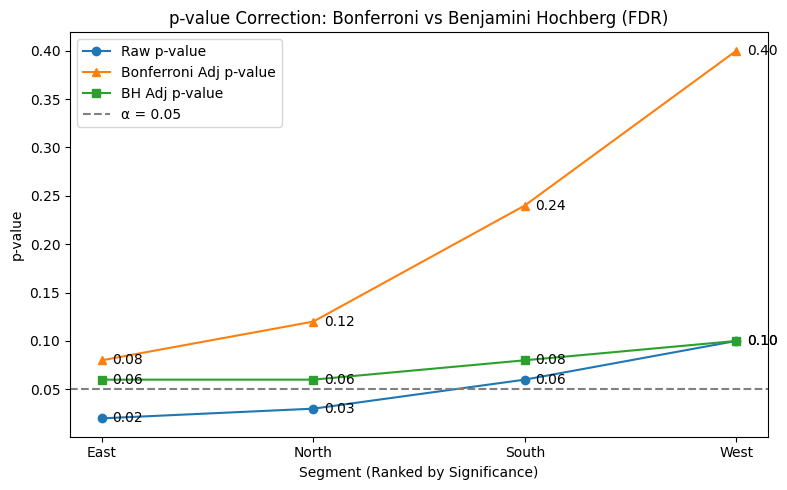

In [56]:
# Plot p values - raw and adjusted

plt.figure(figsize=(8, 5))

# Plot lines
plt.plot(df.index + 1, df['Raw_pValue'], marker='o', label='Raw p-value')
plt.plot(df.index + 1, df['Bonferroni_Adj_pValue'], marker='^', label='Bonferroni Adj p-value')
plt.plot(df.index + 1, df['BH_Adj_pValue'], marker='s', label='BH Adj p-value')

# Add value labels next to each point
for i in range(len(df)):
    x = i + 1
    plt.text(x + 0.05, df['Raw_pValue'][i], f"{df['Raw_pValue'][i]:.2f}", va='center')
    plt.text(x + 0.05, df['Bonferroni_Adj_pValue'][i], f"{df['Bonferroni_Adj_pValue'][i]:.2f}", va='center')
    plt.text(x + 0.05, df['BH_Adj_pValue'][i], f"{df['BH_Adj_pValue'][i]:.2f}", va='center')

# Axis & labels
plt.xticks(df.index + 1, df['Segment']);
plt.axhline(0.05, color='gray', linestyle='--', label='α = 0.05');
plt.xlabel("Segment (Ranked by Significance)");
plt.ylabel("p-value");
plt.title("p-value Correction: Bonferroni vs Benjamini Hochberg (FDR)");
plt.legend();
plt.tight_layout();
plt.show();


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="novelty-effects"></a>
<h4>🪄 Novelty Effects & Behavioral Decay</h4>

<details><summary><strong>📖 Why First Impressions Might Lie (Click to Expand) </strong></summary>

##### 🪄 Novelty Effects & Behavioral Decay
Even if an A/B test shows a statistically significant lift, that improvement may **not last**.

This often happens due to **novelty effects** — short-term spikes in engagement driven by:
- Curiosity (“What’s this new feature?”)
- Surprise (“This looks different!”)
- Visual attention (e.g., placement or color changes)

##### 📉 Common Signs of Novelty Effects
- Strong lift in week 1 → drops by week 3.
- High initial usage → no long-term retention.
- Positive metrics in one segment only (e.g., “new users”).

##### 🧭 What We Do About It

To address this risk during rollouts:
- ✅ Monitor **metrics over time** post-launch (e.g., 7, 14, 28-day retention)
- ✅ Compare results across **early adopters vs late adopters**
- ✅ Run **holdout experiments** during phased rollout to detect fading impact

</details>

<a id="primacy-effect"></a>
<h4>🎯 Primacy Effect & Order Bias</h4>

<details><summary><strong>📖 When First = Best (Click to Expand)</strong></summary>

Sometimes, the **position** of a variant or option can distort results — especially if it's shown **first**. This is called the **primacy effect**, a type of cognitive bias.

It often shows up in:
- Feed ranking or content ordering experiments
- Option selection (e.g., first dropdown item)
- Surveys or in-app prompts

##### 🚩 Common Indicators
- Variant A always performs better **regardless of content**
- Metrics drop when position is swapped
- Discrepancy between test and real-world usage

##### 🧭 What We Do About It
To minimize primacy bias:
- ✅ Randomize order of options or content
- ✅ Use **position-aware metrics** (e.g., click-through by slot)
- ✅ Validate with **follow-up tests** using rotated or reversed orders

</details>


<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="rollout-simulation"></a>

<h4>🎲 Rollout Simulation</h4>

<details><summary><strong>📖 Click to Expand</strong></summary>

<p>Once statistical significance is established, it's useful to simulate <strong>business impact</strong> from full rollout.</p>

<p>Assume full exposure to <strong>eligible daily traffic</strong>, and estimate <strong>incremental impact</strong> from the observed lift.</p>

<p>This helps stakeholders understand the real-world benefit of implementing the change.</p>

<p>We typically estimate:</p>

<ul>
  <li>📈 Daily lift (e.g., additional conversions, dollars, sessions)</li>
  <li>📈 Monthly extrapolation (daily lift × 30)</li>
</ul>

</details>


In [57]:
def simulate_rollout_impact(
    experiment_result,
    daily_eligible_observations,
    metric_unit='conversions'
):
    """
    Estimate potential impact of rolling out the treatment to all eligible traffic.

    Parameters:
    - experiment_result: dict
        Output of `run_ab_test()` — must contain summary + group_labels
    - daily_eligible_observations: int
        Number of eligible units per day (users, sessions, transactions, etc.)
    - metric_unit: str
        What the metric represents (e.g., 'conversions', 'revenue', 'clicks')

    Prints daily and monthly lift estimates.
    """

    group1, group2 = experiment_result['group_labels']
    summary = experiment_result['summary']

    # Extract means
    mean_control = summary[group1]['mean']
    mean_treatment = summary[group2]['mean']
    observed_lift = mean_treatment - mean_control

    # Impact calculation
    daily_impact = observed_lift * daily_eligible_observations
    monthly_impact = daily_impact * 30

    # Output
    print("\n📦 Rollout Simulation")
    print(f"- Outcome Metric      : {metric_unit}")
    print(f"- Observed Lift       : {observed_lift:.4f} per unit")
    print(f"- Daily Eligible Units: {daily_eligible_observations}")
    print(f"- Estimated Daily Impact   : {daily_impact:,.0f} {metric_unit}/day")
    print(f"- Estimated Monthly Impact : {monthly_impact:,.0f} {metric_unit}/month\n")


In [58]:
# Derive daily volume from actual data
daily_traffic_estimate = users.shape[0]  # Assuming full traffic per day

simulate_rollout_impact(
    experiment_result=result,                         # Output from run_ab_test()
    daily_eligible_observations=daily_traffic_estimate,
    metric_unit=test_config['outcome_metric_col']     # Dynamic label like 'engagement_score' or 'revenue'
)



📦 Rollout Simulation
- Outcome Metric      : engagement_score
- Observed Lift       : -0.7146 per unit
- Daily Eligible Units: 1000
- Estimated Daily Impact   : -715 engagement_score/day
- Estimated Monthly Impact : -21,437 engagement_score/month



<hr style="border: none; height: 1px; background-color: #ddd;" />

<a id="ab-test-holdouts"></a>
<h4>🧪 A/B Test Holdouts</h4>

<details><summary><strong>📖 Why We Sometimes Don't Ship to 100% (Click to Expand)</strong></summary>

##### 🧪 A/B Test Holdouts  
Even after a successful A/B test, we often maintain a **small holdout group** during rollout.

This helps us:
- Track **long-term impact** beyond the experiment window.
- Detect **novelty fade** or **unexpected side effects**.
- Maintain a clean “control” for system-wide benchmarking.

##### 🏢 Industry Practice  
- Common at large orgs like **Facebook**, where teams share a holdout pool for all feature launches.
- Holdouts help leadership evaluate **true impact** during performance reviews and roadmap planning.

##### ⚠️ When We Skip Holdouts  
- **Bug fixes** or critical updates (e.g., spam, abuse, policy violations).
- **Sensitive changes** like content filtering (e.g., child safety flags).

</details>


<a id="ab-test-limits"></a>
<h4>🚫 Limits & Alteratives</h4>

<details><summary><strong>📉 When Not to A/B Test & What to Do Instead (Click to Expand)</strong></summary>

##### 🙅‍♀️ When Not to A/B Test
- **Lack of infrastructure** → No tracking, engineering, or experiment setup.
- **Lack of impact** → Not worth the effort if the feature has minimal upside, shipping features has downstream implications (support, bugs, operations)..
- **Lack of traffic** → Can’t reach stat sig in a reasonable time.
- **Lack of conviction** → No strong hypothesis; testing dozens of variants blindly.
- **Lack of isolation** → Hard to contain exposure (e.g., testing a new logo everyone sees).

##### 🧪 Alternatives & Edge Cases
- Use **user interviews or logs** to gather directional signals.
- Leverage **retrospective data** for pre/post comparisons.
- Consider **sequential testing** or **soft rollouts** for low-risk changes.
- Use **design experiments** (e.g., multivariate, observational) when randomization isn't feasible.

</details>

[Back to the top](#table-of-contents)
___
